Ilinca Bianca Mitrea Mitrea 100495772

David Mancebo Barrena 100495917

# 1.EDA

Importaciones previas 

In [157]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

## Número de variables e instancias

In [158]:
df = pd.read_csv("attrition_availabledata_08.csv")
print("Número de instancias:", df.shape[0])
print("Número de variables:", df.shape[1])


Número de instancias: 2940
Número de variables: 31


## Tipo de variables

Identificamos el tipo de cada variable en el dataset. Esto nos servirá para determinar cómo debemos preprocesar los datos.

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      2940 non-null   float64
 1   absences                 2940 non-null   int64  
 2   JobInvolvement           2940 non-null   int64  
 3   PerformanceRating        2940 non-null   int64  
 4   EnvironmentSatisfaction  2923 non-null   float64
 5   JobSatisfaction          2928 non-null   float64
 6   WorkLifeBalance          2916 non-null   float64
 7   Age                      2940 non-null   int64  
 8   BusinessTravel           2940 non-null   object 
 9   Department               2940 non-null   object 
 10  DistanceFromHome         2940 non-null   int64  
 11  Education                2940 non-null   int64  
 12  EducationField           2940 non-null   object 
 13  EmployeeCount            2940 non-null   int64  
 14  EmployeeID              

In [160]:
# Seleccionar variables numéricas
numeric_vars = df.select_dtypes(include=['number'])
print("Variables numéricas:", numeric_vars.columns)
print("Número de variables numéricas:", len(numeric_vars.columns))

# Seleccionar variables categóricas
categorical_vars = df.select_dtypes(include=['object'])
print("Variables categóricas:", categorical_vars.columns)
print("Número de variables categóricas:", len(categorical_vars.columns))

Variables numéricas: Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID',
       'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')
Número de variables numéricas: 23
Variables categóricas: Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'Attrition'],
      dtype='object')
Número de variables categóricas: 8


In [161]:
cardinality = categorical_vars.nunique().sort_values(ascending=False)
print("Cardinalidad de cada variable categórica:")
print(cardinality)

Cardinalidad de cada variable categórica:
JobRole           9
EducationField    6
Department        3
BusinessTravel    3
MaritalStatus     3
Gender            2
Attrition         2
Over18            1
dtype: int64


Observamos que las variables con mayor cardinalidad son JobRole, con una cardinalidad de 9, y EducationField, con una cardinalidad de 6. Tenemos una cardinalidad moderada en general, lo que significa que One-Hot Encoding para transformar las variables categóricas es viable sin generar un número excesivo de columnas. 


## Columnas constantes e identificadores

Vamos a detectar conlumnas constantes que no aportan información útil para la predicción sino que solo aumenta la carga computacional. 

In [162]:
# Contar valores únicos por columna
constant_cols = df.nunique()[df.nunique() == 1]

print("Columnas constantes:")
print(constant_cols)

Columnas constantes:
EmployeeCount    1
Over18           1
StandardHours    1
dtype: int64


Es importante también observar si tenemos identificadores únicos en el dataset, ya que no aportan ninguna información útil a la predicción.

In [163]:
# Contar valores únicos en cada columna y compararlos con el número de filas
id_cols = df.nunique()[df.nunique() == df.shape[0]]

print("\nColumnas de ID:")
print(id_cols)


Columnas de ID:
EmployeeID    2940
dtype: int64


## Tipo de problema

En este caso, la variable Attrition indica si un empleado renuncia, por lo que es un problema de clasificación.

## Desbalanceo de datos


In [164]:
# Contar las instancias por cada clase
conteo = df['Attrition'].value_counts()
print("Conteo por clase:")
print(conteo)

# Calcular el porcentaje de cada clase
porcentajes = df['Attrition'].value_counts(normalize=True) * 100
print("\nPorcentaje por clase:")
print(porcentajes)

Conteo por clase:
Attrition
No     2466
Yes     474
Name: count, dtype: int64

Porcentaje por clase:
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


También podemos visualizar la distribución con un gráfico de barras

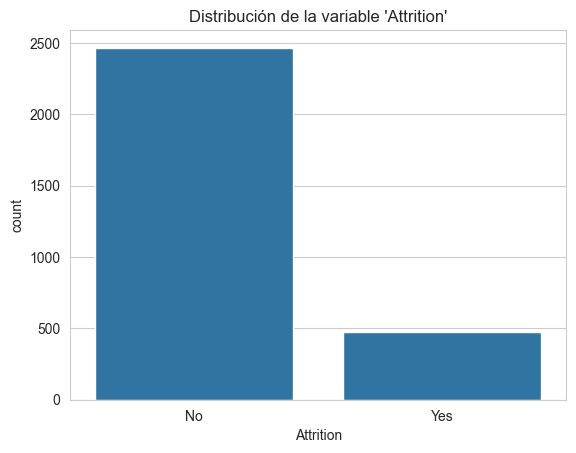

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Attrition', data=df)
plt.title("Distribución de la variable 'Attrition'")
plt.show()


Sí, el dataset está desbalanceado porque la clase mayoritaria ("No" - empleados que no abandonan la empresa) representa el 83.88% de los datos, mientras que la clase minoritaria ("Yes" - empleados que abandonan la empresa) solo representa el 16.12%.
Esto nos hace considerar usar SMOTE para aumentar la clase minoritaria (oversampling)



## Visualización gráfica de los atributos 
Es muy útil  usar seaborn y matplotlib para mostrar los histogramas y barplots de las columnas no constantes/ID para visualizar mejor los datos con los que vamos a trabajar


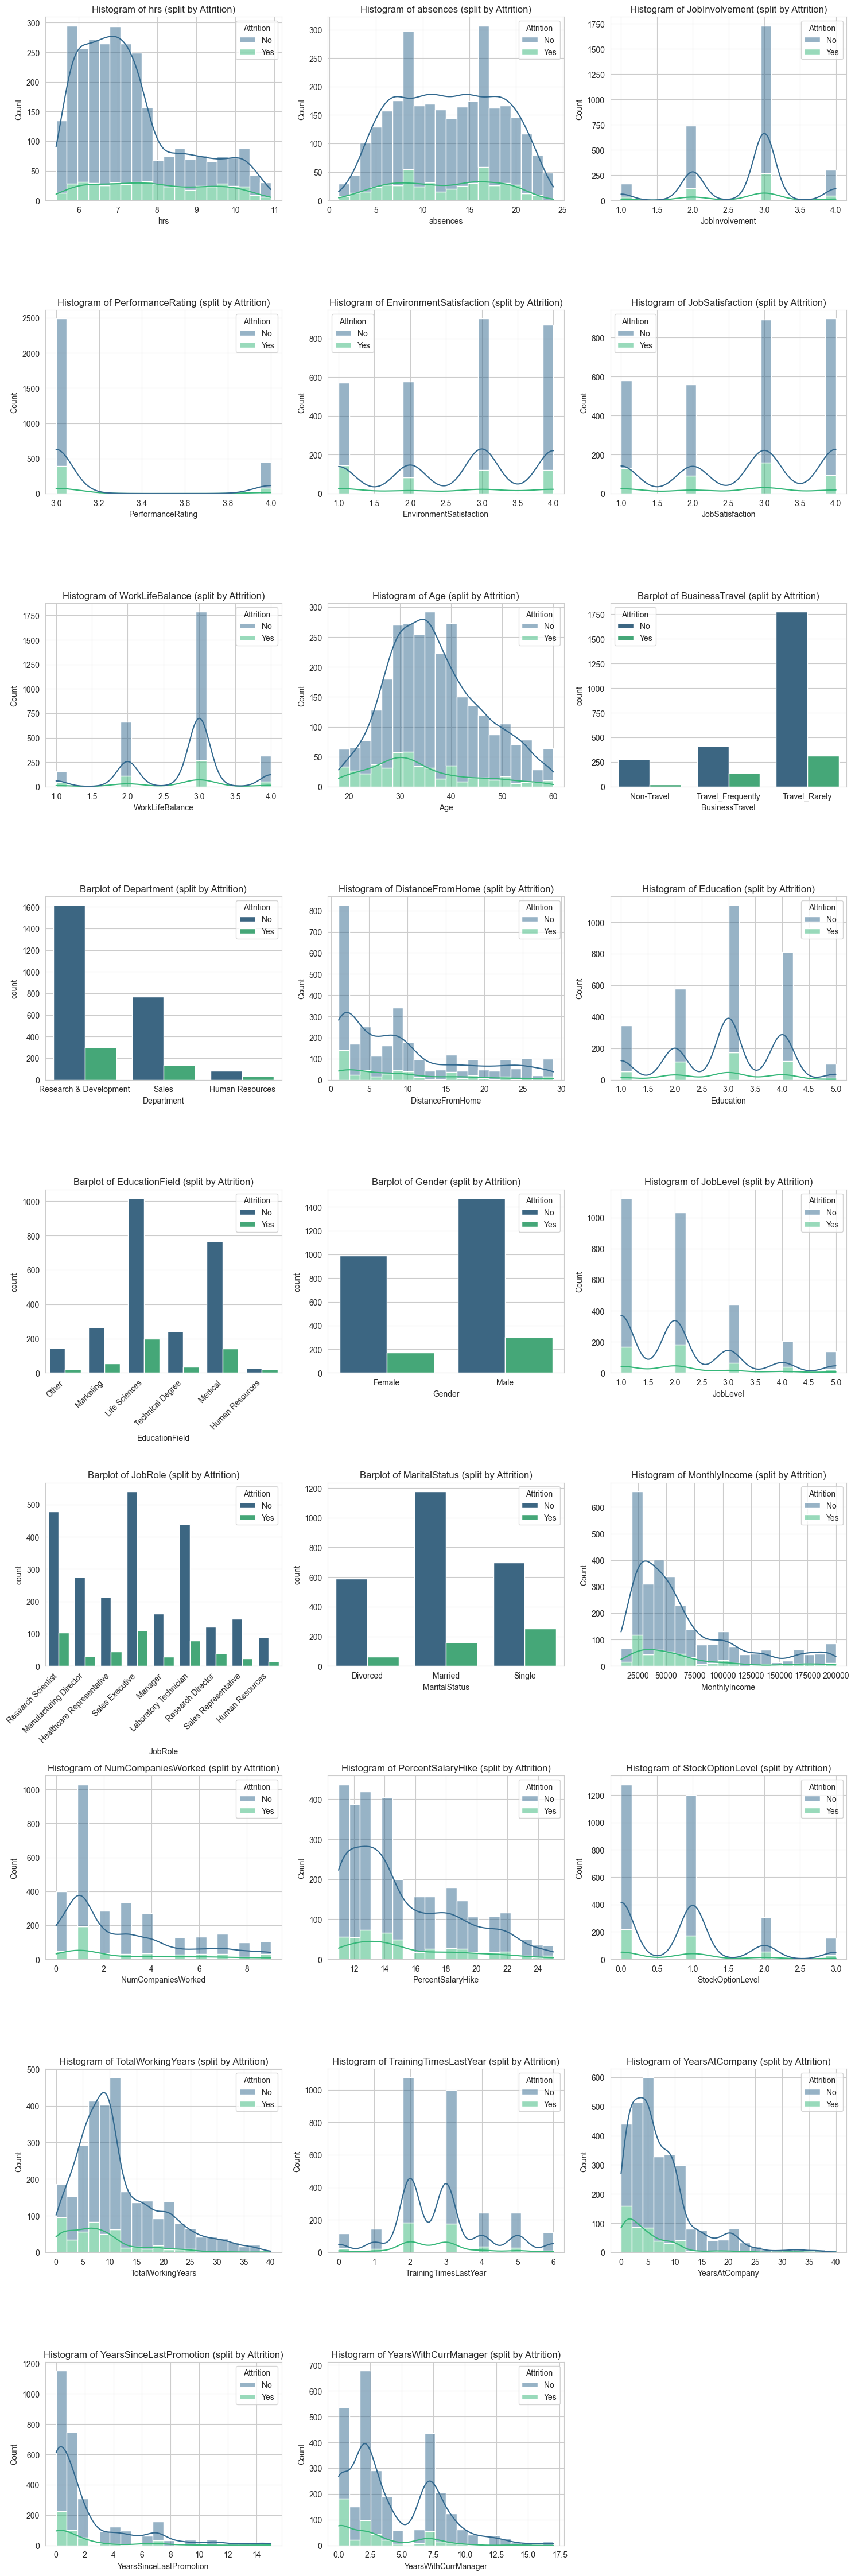

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ignoramos las columnas constantes/ID y Attrition
valid_columns = [col for col in df.columns if col != "Attrition" and df[col].nunique() != 1 and df[col].nunique() != df.shape[0]]
n_cols = len(valid_columns)
n_rows = (n_cols // 3) + (1 if n_cols % 3 != 0 else 0)  # mostramos los histogramas en 3 columnas 

# Figure para mostrar los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Iteramos sobre las columnas válidas del dataset para mostrar los plots de cada una
for idx, column in enumerate(valid_columns, 1):
    plt.subplot(n_rows, 3, idx)
    
    # Definimos histograma (num) o barplot (cat) dependiendo del tipo de datos
    
    # Variables numéricas
    if df[column].dtype in ['int64', 'float64']:
        sns.histplot(df, x=column, hue="Attrition", kde=True, bins=20, palette='viridis', multiple="stack")
        plt.title(f"Histogram of {column} (split by Attrition)")
        
    # Variables categóricas
    elif df[column].dtype == 'object':
        sns.countplot(x=df[column], hue=df["Attrition"], palette='viridis')
        plt.title(f"Barplot of {column} (split by Attrition)")
        
        # Si hay más de 4 categorías rotamos las labels para que no intersecten
        if df[column].nunique() > 4:
            plt.xticks(rotation=45, ha='right')
 
    plt.tight_layout()  # Para evitar que los plots intersecten entre ellos

plt.show()


Después de un primer contacto con los datos, hemos identificado los pasos relevantes del preprocesamiento de los datos para preparar el dataset antes de entrenar el modelo. Haremos lo siguiente:
1. Eliminar columnas irrelvenates: identificadores úncios y variables constantes.
2. Manejar valores faltantes mediante imputación.
2. Codificar variables categóricas y ordinales.
3. Escalar variables numéricas.
4. Manejar el desbalanceo de clases mediante SMOTE.

Vamos a hacer el preproceso de datos mediante un pipeline para evitar information leakage.

Usaremos un pipeline de preprocesamiento que incluya:

- Encoding (One-Hot y Label/Ordinal Encoding según corresponda)
- Imputación de valores faltantes

Esto asegurará que el preprocesamiento se realice de manera consistente en train y test, evitando errores y asegurando reproducibilidad.

Pero antes de hacer el pipeline, podemos hacer:
- Eliminación de atributos constantes
- Eliminación de identificadores

Estas eliminaciones son transformaciones independeientes del conjunto de entrenamiento y no introducen riesgos de data leakage por lo que se pueden realizar una sola vez antes del entrenamiento.

## Eliminar atributos constantes e identificadores

Ya hemos visto previamente que tenemos 3 columnas constantes y una columna ID. Vamos a eliminarlas porque no aportan información relevante.

In [167]:
original_columns = set(df.columns)

id_columns = ['EmployeeID'] 
df = df.drop(columns=id_columns, errors='ignore')

# Eliminar columnas constantes
constant_columns = [col for col in df.columns if df[col].nunique() <= 1]
df = df.drop(columns=constant_columns, errors='ignore')

# Mostrar las columnas eliminadas
removed_columns = original_columns - set(df.columns)
if removed_columns:
    print("Columnas eliminadas:")
    print(list(removed_columns))
else:
    print("No se eliminaron columnas.")

Columnas eliminadas:
['StandardHours', 'EmployeeID', 'EmployeeCount', 'Over18']


Después de haber eliminado los atributos innecesarios, vamos a volver a visualizar los atributos restantes y su clasificación.

In [168]:
# Variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
print("Variables categóricas:", categorical_cols)


Variables categóricas: Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Attrition'],
      dtype='object')


Vamos a identificar las variables ordinales dentro de las variables categóricas para determinar qué tipo de encoding haremos para cada variable en función de si es categórica nominal u ordinal.

In [169]:
# Valores únicos por cada variable categórica
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].unique())



BusinessTravel:
['Non-Travel' 'Travel_Frequently' 'Travel_Rarely']

Department:
['Research & Development' 'Sales' 'Human Resources']

EducationField:
['Other' 'Marketing' 'Life Sciences' 'Technical Degree' 'Medical'
 'Human Resources']

Gender:
['Female' 'Male']

JobRole:
['Research Scientist' 'Manufacturing Director' 'Healthcare Representative'
 'Sales Executive' 'Manager' 'Laboratory Technician' 'Research Director'
 'Sales Representative' 'Human Resources']

MaritalStatus:
['Divorced' 'Married' 'Single']

Attrition:
['No' 'Yes']


Vemos que todas las variables categóricas con nominales, excepto BusinessTravel que es ordinal porque tiene un orden implícito. Además, attrition y gender pueden tratarse como variables binarias.

Para variables ordinales: usamos Label Encoding

Para variables nominales: usamos One-Hot Encoding

Para variables binarias: convertimos a 0 y 1


In [170]:
# Identificar columnas categóricas y numéricas

all_categorical = df.select_dtypes(include=['object']).columns.tolist()

# Eliminar la variable target de las categóricas porque no debe ser preprocesada junto con las variables del conjunto de entrenamiento
target = 'Attrition'
if target in all_categorical:
    all_categorical.remove(target)
    
# Definimos la variable ordinal
ordinal_cols = ['BusinessTravel']

# Las columnas categóricas nominales serán las categóricas menos las ordinales
categorical_cols = [col for col in all_categorical if col not in ordinal_cols]

numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Imprimimos resultados
print("Number of ordinal columns:", len(ordinal_cols))
print("Ordinal columns:", ordinal_cols)
for col in ordinal_cols:
    # Obtener valores únicos y ordenarlos
    ordinal_values = [sorted(df[col].dropna().unique()) for col in ordinal_cols]
    print("Values of ", ordinal_cols, ": ", ordinal_values)
print("Number of nominal columns:", len(categorical_cols))
print("Nominal columns:", categorical_cols)
print("Number of numerical columns:", len(numerical_cols))
print("Numerical columns:", numerical_cols)

Number of ordinal columns: 1
Ordinal columns: ['BusinessTravel']
Values of  ['BusinessTravel'] :  [['Non-Travel', 'Travel_Frequently', 'Travel_Rarely']]
Number of nominal columns: 5
Nominal columns: ['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
Number of numerical columns: 20
Numerical columns: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


Esta información nos servirá para la parte de encoding dentro de la definición de pipeline que utilizaremos en el preprocesamiento.

## Valores faltantes
La imputación se debe hacer solo con los datos de entrenamiento, ya que los datos de test son datos del futuro y, por tanto, debemos suponer que no los conocemos para evitar information leakage o fuga de información. 

Para hacer imputación cuando puede ocurrir information leakage, lo correcto es construir un pipeline.

Si tenemos que imputar los atributos del conjunto de test, usaremos las medias o mediana calculadas con el conjunto de entrenamiento (reimputación), para evitar fuga de información del conjunto de test.

In [171]:
# Valores faltantes en variables numéricas
num_missing = df[numerical_cols].isnull().sum()
num_missing_percent = (num_missing / len(df)) * 100

# Filtrar solo las columnas con valores faltantes
missing_numerical = pd.DataFrame({
    'Missing Count': num_missing,
    'Missing Percent': num_missing_percent
}).query('`Missing Count` > 0').sort_values(by='Missing Count', ascending=False)

print("Valores faltantes en variables numéricas:")
if not missing_numerical.empty:
    print(missing_numerical)
else:
    print("No hay valores faltantes en variables numéricas.")

# Valores faltantes en variables categóricas nominales
missing_nominal = df[categorical_cols].isnull().sum()
missing_nominal_percent = (missing_nominal / len(df)) * 100

# Filtrar solo las columnas con valores faltantes
missing_nominal_df = pd.DataFrame({
    'Missing Count': missing_nominal,
    'Missing Percent': missing_nominal_percent
}).query('`Missing Count` > 0').sort_values(by='Missing Count', ascending=False)

print("\nValores faltantes en variables categóricas nominales:")
if not missing_nominal_df.empty:
    print(missing_nominal_df)
else:
    print("No hay valores faltantes en variables categóricas nominales.")

# Valores faltantes en variables ordinales
missing_ordinal = df[ordinal_cols].isnull().sum()
missing_ordinal_percent = (missing_ordinal / len(df)) * 100

# Filtrar solo las columnas con valores faltantes
missing_ordinal_df = pd.DataFrame({
    'Missing Count': missing_ordinal,
    'Missing Percent': missing_ordinal_percent
}).query('`Missing Count` > 0').sort_values(by='Missing Count', ascending=False)

print("\nValores faltantes en variables ordinales:")
if not missing_ordinal_df.empty:
    print(missing_ordinal_df)
else:
    print("No hay valores faltantes en variables ordinales.")


Valores faltantes en variables numéricas:
                         Missing Count  Missing Percent
WorkLifeBalance                     24         0.816327
EnvironmentSatisfaction             17         0.578231
JobSatisfaction                     12         0.408163
NumCompaniesWorked                  11         0.374150
TotalWorkingYears                    4         0.136054

Valores faltantes en variables categóricas nominales:
No hay valores faltantes en variables categóricas nominales.

Valores faltantes en variables ordinales:
No hay valores faltantes en variables ordinales.


Tenemos valores faltantes solo en variables numéricas. Además, con porcentajes muy bajos (menos de 1% en cada una), por lo que el problema es leve. Se considerarán la media y la mediana para imputar los valores numéricos faltantes.

Aunque en nuestro dataset no tenemos valores faltantes en atributos categóricos y ordinales, vamos a utilizar imputación mediante moda para estas variables (ya que no toman valores numéricos, no podemos usar mediana ni media). Esto nos da mayor flexibilidad y robustez por si nuestro dataset cambia en un futuro.


## Escalado
Variables numéricas como Age, MonthlyIncome, DistanceFromHome, etc., pueden tener escalas muy diferentes y para modelos como KNN es importante escalar estas variables para dar la misma importancia a todas las variables. Por si acaso, vamos a escalar también las variables categóricas y ordinales después del encoding. Se considerarán tres métodos de escalado (minmax, standard, robust).


# Holdout

La estimación del rendimiento futuro (o evaluación outer) se realizará con Holdou (train (2/3) / test (1/3)). Por ello, antes de empezar con el entrenamiento de los modelos y la optimización de hiperparámetros, debemos dividir los datos en train y test. Antes de esa división en train y test, recordemos que debemos codificar la variable objetivo, convirtiendo attrition de una variable categórica ('No', 'Yes') a valores numéricos como variable binaria (0 y 1).

In [172]:
# SEPARACIÓN ENTRE VARIABLES Y DIVISIÓN TRAIN/TEST
X = df.drop(columns=['Attrition'])
y = df['Attrition']


# Encoding de la variable de decisión
y = y.map({'No': 0, 'Yes': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, random_state=72, stratify=y
)

print(f"Tamaño de Train: {X_train.shape}, Tamaño de Test: {X_test.shape}")


Tamaño de Train: (1960, 26), Tamaño de Test: (980, 26)


## Selección de la mejor estrategia de preprocesamiento

Para evaluar los diferentes métodos de imputación y escalado y encontrar la combinación óptima de hiperparámetros para el preprocesamiento de los datos, seeguiremos la siguiente estrategia:

1. Imputación en variables numéricas. Probamos dos estrategias:

- Media
- Mediana

2. Escalado en variables numéricas (y en general en el conjunto transformado).
Evaluamos tres métodos:

- StandardScaler
- MinMaxScaler
- RobustScaler

3. Usar un pipeline que incluya el preprocesamiento (imputación y encoding) y el escalado, seguido de un clasificador KNN.

4. Aplicar GridSearchCV para explorar las combinaciones de imputador y escalador utilizando la métrica balanced accuracy.

In [173]:
from sklearn.model_selection import KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Para variables numéricas: imputación con mediana y escalado
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Para variables categóricas nominales: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Para variables ordinales: OrdinalEncoder con el orden definido
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[["Non-Travel", "Travel_Rarely", "Travel_Frequently"]])),
    ('scaler', StandardScaler())
])

# COMBINACIÓN DE TRANSFORMACIONES (AÚN SIN ESCALADO)
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols),
    ('ord', ordinal_transformer, ordinal_cols)
])


# PIPELINE GLOBAL: PRIMERO TRANSFORMACIÓN, LUEGO ESCALADO
pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),  # Primero se hace imputación y encoding
    ('smote', SMOTE(random_state=72)),
    ('classifier', KNeighborsClassifier())
])

# Definir la grilla de parámetros para el GridSearchCV:
param_grid = {
    # Imputación: 'mean' o 'median' para variables numéricas
    'preprocessing__num__imputer__strategy': ['mean', 'median'],
    # Escalado: probar MinMaxScaler, StandardScaler y RobustScaler
    'preprocessing__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
}

# Configurar GridSearchCV usando balanced_accuracy como métrica (dado el desbalanceo)
inner = StratifiedKFold(n_splits=10, shuffle=True, random_state=72)
grid_search = GridSearchCV(pipeline, param_grid, cv=inner, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_preprocessor = grid_search.best_estimator_ # mejor model del INNER LOOP

# Extraer los inner scores de GridSearchCV
inner_scores = pd.DataFrame(grid_search.cv_results_)

# Seleccionar solo las columnas clave
inner_scores = inner_scores[
    ['param_preprocessing__num__imputer__strategy',
     'param_preprocessing__num__scaler',
     'mean_test_score', 'std_test_score', 'rank_test_score']
]

# Ordenar por la mejor precisión balanceada
inner_scores = inner_scores.sort_values(by='mean_test_score', ascending=False)

# Mostrar resultados
print("Resultados de Validación Cruzada (INNER LOOP)")
display(inner_scores)

print("Mejor combinación de parámetros:")
print(grid_search.best_params_)
print("Mejor Balanced Accuracy (CV):", grid_search.best_score_)



Fitting 10 folds for each of 6 candidates, totalling 60 fits
Resultados de Validación Cruzada (INNER LOOP)


,param_preprocessing__num__imputer__strategy,param_preprocessing__num__scaler,mean_test_score,std_test_score,rank_test_score
3,median,MinMaxScaler(),0.773494,0.045142,1
0,mean,MinMaxScaler(),0.772888,0.044902,2
1,mean,StandardScaler(),0.766650,0.028996,3
4,median,StandardScaler(),0.766648,0.029162,4
5,median,RobustScaler(),0.762663,0.037361,5
2,mean,RobustScaler(),0.762362,0.036371,6


Mejor combinación de parámetros:
{'preprocessing__num__imputer__strategy': 'median', 'preprocessing__num__scaler': MinMaxScaler()}
Mejor Balanced Accuracy (CV): 0.7734941244665379


In [174]:
# Información de ayuda para entender cómo funciona el pipeline
print("Pasos en el preprocesador:")
print(best_preprocessor.steps)

Pasos en el preprocesador:
[('preprocessing', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['hrs', 'absences', 'JobInvolvement',
                                  'PerformanceRating',
                                  'EnvironmentSatisfaction', 'JobSatisfaction',
                                  'WorkLifeBalance', 'Age', 'DistanceFromHome',
                                  'Education', 'JobLevel', 'MonthlyIncome',
                                  'NumCompaniesWorked', 'PercentSalaryHike',...
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
               

Necesitamos X_train_transformed porque el GridSearchCV de KNN trabajará con los datos ya transformados. 

In [175]:
# Transformar los datos de entrenamiento con el mejor preprocesamiento
X_train_transformed = best_preprocessor.named_steps['preprocessing'].transform(X_train)
# Transformar los datos de test con el mejor preprocesamiento
X_test_transformed = best_preprocessor.named_steps['preprocessing'].transform(X_test)
print("Forma de X_train antes de la transformación:", X_train.shape)
print("Forma de X_train después de la transformación:", X_train_transformed.shape)


# Para comprobar que ya no hay valores nulos
feature_names = best_preprocessor.named_steps['preprocessing'].get_feature_names_out()
#print(feature_names)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
print(X_train_transformed_df['ord__BusinessTravel'])
print(X_train_transformed_df.isnull().sum().sum())  # Debe ser 0 si la imputación funcionó


Forma de X_train antes de la transformación: (1960, 26)
Forma de X_train después de la transformación: (1960, 39)
0      -0.147219
1       1.738729
2      -0.147219
3      -0.147219
4      -0.147219
          ...   
1955   -2.033168
1956   -2.033168
1957    1.738729
1958   -0.147219
1959    1.738729
Name: ord__BusinessTravel, Length: 1960, dtype: float64
0


## Comprobaciones del preprocesamiento

Para verificar que el preprocesamiento se hace correctamente podemos visualizar los datos originales y los datos transformados en dos histogramas.

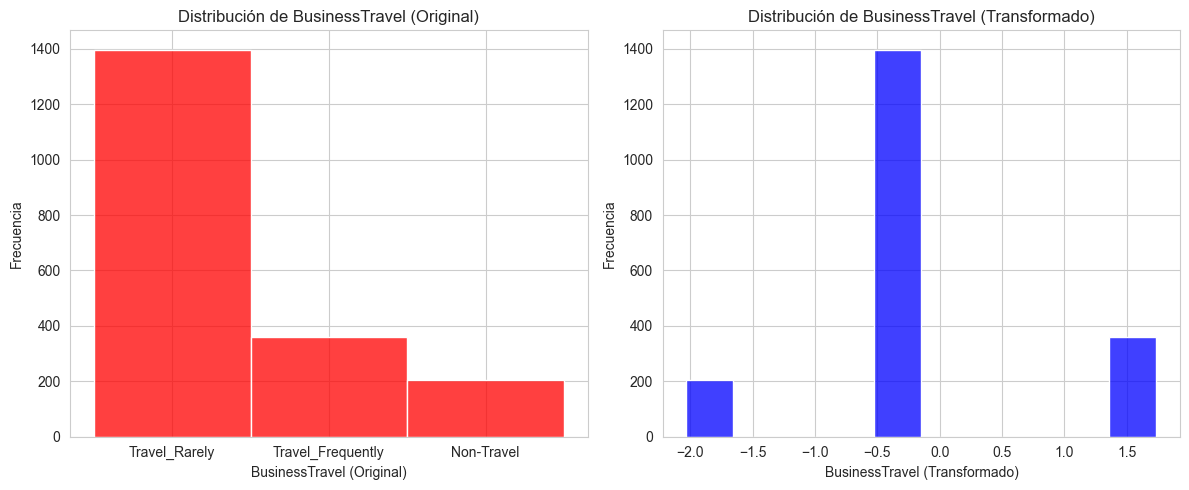

In [176]:
# Crear dos gráficos separados para visualizar la variable ordinal BusinessTravel antes y después de la transformación de OrdinalEncoder()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: Distribución de la variable original
sns.histplot(X_train['BusinessTravel'], bins=10, color="red", ax=axes[0])
axes[0].set_xlabel("BusinessTravel (Original)")
axes[0].set_ylabel("Frecuencia")
axes[0].set_title("Distribución de BusinessTravel (Original)")
axes[0].grid(True)

# Gráfico 2: Distribución de la variable transformada
sns.histplot(X_train_transformed_df['ord__BusinessTravel'], bins=10, color="blue", ax=axes[1])
axes[1].set_xlabel("BusinessTravel (Transformado)")
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Distribución de BusinessTravel (Transformado)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


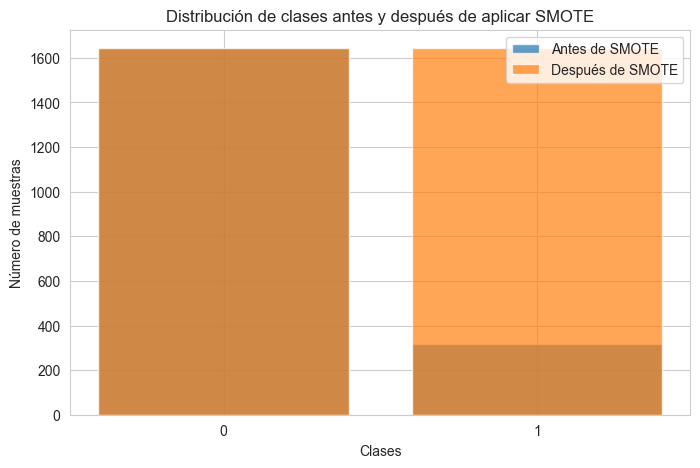

In [177]:
# Para comprobar que SMOTE funciona bien, aplicamos SMOTE fuera de la pipeline para ver la diferencia
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Contar la distribución de clases antes y después de SMOTE
class_counts_before = y_train.value_counts()
class_counts_after = y_train_resampled.value_counts()

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(class_counts_before.index.astype(str), class_counts_before.values, alpha=0.7, label="Antes de SMOTE")
plt.bar(class_counts_after.index.astype(str), class_counts_after.values, alpha=0.7, label="Después de SMOTE")
plt.xlabel("Clases")
plt.ylabel("Número de muestras")
plt.title("Distribución de clases antes y después de aplicar SMOTE")
plt.legend()
plt.show()


# Dummy Classifier
En el enunciado de la práctica se indica que comparemos los resultados del modelo naive/dummy con los modelos KNN y trees conseguidos, así que vamos a obtener los resultados del dummy classifier primero antes de empezar con los metodos básicos.

In [178]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_transformed, y_train)

DummyClassifier(strategy='most_frequent')

En la fase inner, en lugar de usar un conjunto X_test fijo, utilizaremos validación cruzada sobre el conjunto de entrenamiento para evaluar y comparar las alternativas sin "filtrar información" (data leakage) al modelo. Esto nos permite obtener estimaciones de rendimiento (como balanced accuracy, TPR, TNR, y la matriz de confusión) basadas únicamente en datos de entrenamiento.



In [179]:
# Generar predicciones usando validación cruzada (por ejemplo, con 5 folds)
y_pred_inner = cross_val_predict(dummy_clf, X_train_transformed, y_train, cv=5)

# Calcular métricas usando las etiquetas reales del conjunto de entrenamiento
balanced_acc_inner = balanced_accuracy_score(y_train, y_pred_inner)
print(f"Balanced Accuracy (inner): {balanced_acc_inner:.4f}")

# Imprimir reporte de clasificación
dummy_cr_inner = classification_report(y_train, y_pred_inner, zero_division=0)
print("Classification report (inner):\n", dummy_cr_inner)

# Mostrar la matriz de confusión
conf_matrix_inner = confusion_matrix(y_train, y_pred_inner)
print("Matriz de confusión (inner):\n", conf_matrix_inner)

Balanced Accuracy (inner): 0.5000
Classification report (inner):
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      1644
           1       0.00      0.00      0.00       316

    accuracy                           0.84      1960
   macro avg       0.42      0.50      0.46      1960
weighted avg       0.70      0.84      0.77      1960

Matriz de confusión (inner):
 [[1644    0]
 [ 316    0]]


# HPO con KNN

## KNN: Entrenamiento con hiperparámetros por omisión

El clasificador KNeighborsClassifier de scikit-learn tiene los siguientes parámetros por defecto:

- n_neighbors = 5
- weights = 'uniform': Todos los vecinos tienen el mismo peso (votación uniforme).
- algorithm = 'auto': Se elige automáticamente el algoritmo adecuado (ball_tree, kd_tree o brute force) según los datos.
- leaf_size = 30: Tamaño de hoja para la construcción de Ball Tree o KD Tree.
- p = 2: Se utiliza la distancia de Minkowski con  p=2 (equivalente a la distancia Euclidiana).
- metric = 'minkowski': Métrica de distancia utilizada para calcular las distancias entre puntos.
- metric_params = None: No se especifican parámetros adicionales para la métrica.
- n_jobs = None: No se usa paralelización (se ejecuta en un solo núcleo por defecto).

In [180]:
import time

knn_default = KNeighborsClassifier()  # Hiperparámetros por defecto

start_time = time.time()
knn_default.fit(X_train_transformed, y_train)
default_time_fit = time.time() - start_time

start_time = time.time()
y_pred_default = knn_default.predict(X_test_transformed)
default_time_predict = time.time() - start_time
default_score = balanced_accuracy_score(y_test, y_pred_default)

print("Modelo con hiperparámetros por omisión:")
print(f"Balanced Accuracy: {default_score:.4f}")
print(f"Tiempo de entrenamiento de KNN default: {default_time_fit:.8f} segundos")
print(f"Tiempo de predicción de KNN default: {default_time_predict:.8f} segundos")


Modelo con hiperparámetros por omisión:
Balanced Accuracy: 0.6009
Tiempo de entrenamiento de KNN default: 0.00299406 segundos
Tiempo de predicción de KNN default: 0.01396108 segundos


## KNN: Evaluación de alternativas con ajustes de hiper-parámetros (HPO)

Realizaremos una búsqueda de hiperparámetros HPO para optimizar un clasificador KNN utilizando validación cruzada interna.

In [181]:
inner_scores_out = []

# Ahora entrenamos KNN con diferentes valores de n_neighbors
param_grid_knn = {
    'n_neighbors': [2, 3, 4, 5, 6, 7],  # Diferentes valores de vecinos
    'weights': ['uniform', 'distance'],  # Cómo se ponderan los vecinos
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Tipo de métrica
    'p': [3]
}

inner = StratifiedKFold(n_splits=10, shuffle=True, random_state=72)


grid_knn = GridSearchCV(
    KNeighborsClassifier(), param_grid_knn,
    cv=inner, scoring='balanced_accuracy', n_jobs=-1, verbose=3
)

start_time = time.time()
grid_knn.fit(X_train_transformed, y_train)
hpo_time = time.time() - start_time

# Crear DataFrame con los resultados de GridSearchCV
inner_scores_df = pd.DataFrame(grid_knn.cv_results_)[
    ['param_n_neighbors', 'param_weights', 'param_metric', 'param_p', 
     'mean_test_score', 'std_test_score', 'rank_test_score']
]

# Añadir los resultados actuales a la lista
inner_scores_out.append(inner_scores_df)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


In [182]:
# Obtener el mejor modelo KNN
best_knn = grid_knn.best_estimator_
start_time = time.time()
best_knn.fit(X_train_transformed, y_train)
best_knn_time = time.time() - start_time

print("\nHPO KNN:", grid_knn.best_params_)
print(f"Tiempo de entrenamiento (incluyendo HPO): {hpo_time+best_knn_time:.2f} segundos")
print(f"Tiempo de entrenamiento del modelo KNN default: {default_time_fit:.8f} segundos")
print(f"Mejora en el tiempo de entrenamiento del modelo default con respecto al modelo que utiliza los HP optimizados = {(hpo_time+best_knn_time)/default_time_fit}")


HPO KNN: {'metric': 'manhattan', 'n_neighbors': 2, 'p': 3, 'weights': 'distance'}
Tiempo de entrenamiento (incluyendo HPO): 7.24 segundos
Tiempo de entrenamiento del modelo KNN default: 0.00299406 segundos
Mejora en el tiempo de entrenamiento del modelo default con respecto al modelo que utiliza los HP optimizados = 2417.938127090301


Observamos que encontrar los HP óptimos y entrenar el modelo óptimo tarda alrededor de 7000 veces más  que entrenar el modelo utilizando los HP por defecto.

## Resultados de KNN con HPO: balanced accuracy, TPR / TNR, accuracy y confusion matrix (inner)
Recordemos que durante la optimización de hiperparámetros (evaluación inner), no se debe usar el conjunto de test completo. Por eso aplicamos validación cruzada sobre el conjunto de entrenamiento para estimar el rendimiento de los modelos.

Para evaluar internamente sin usar el conjunto de test, utilizaremos la función cross_val_predict para obtener las predicciones de validación para cada muestra del conjunto de entrenamiento, y luego calcular las métricas de interés. 

Realizamos validación cruzada KFold en la que para cada iteración, el modelo se entrena con k-1 folds y se evalúa en el fold restante. En cada fold se calculan métricas como el balanced accuracy, accuracy, y se genera la matriz de confusión


In [183]:
# Utilizamos cross_val_predict para obtener predicciones en validación cruzada sin usar X test de momento
y_pred_cv = cross_val_predict(best_knn, X_train_transformed, y_train, cv=5)

# Calcular las métricas en el conjunto de entrenamiento (evaluación inner)
inner_bal_acc = balanced_accuracy_score(y_train, y_pred_cv)
inner_acc = accuracy_score(y_train, y_pred_cv)
inner_conf_matrix = confusion_matrix(y_train, y_pred_cv)
inner_class_report = classification_report(y_train, y_pred_cv)

print("Evaluación Inner (Validación Cruzada):")
print(f"Balanced Accuracy: {inner_bal_acc:.4f}")
print(f"Accuracy: {inner_acc:.4f}")
print("Classification Report:")
print(inner_class_report)
print("Matriz de Confusión:")
print(inner_conf_matrix)

# Calcular TPR y TNR a partir de la matriz de confusión
tn, fp, fn, tp = inner_conf_matrix.ravel()
TPR = tp / (tp + fn) 
TNR = tn / (tn + fp)  
print(f"TPR: {TPR:.4f}")
print(f"TNR: {TNR:.4f}")


Evaluación Inner (Validación Cruzada):
Balanced Accuracy: 0.8401
Accuracy: 0.9097
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1644
           1       0.71      0.74      0.72       316

    accuracy                           0.91      1960
   macro avg       0.83      0.84      0.84      1960
weighted avg       0.91      0.91      0.91      1960

Matriz de Confusión:
[[1550   94]
 [  83  233]]
TPR: 0.7373
TNR: 0.9428


### KNN HPO: Matriz de confusión

Vamos a visualizar la matriz de confusion en un gráfico de calor.

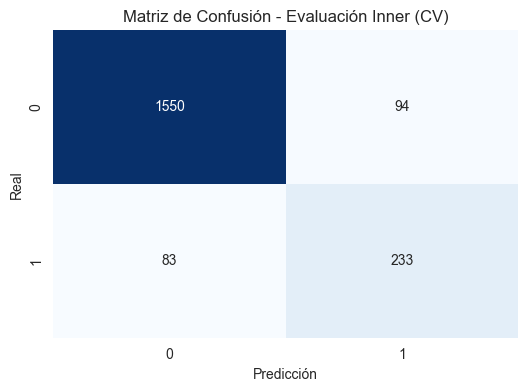

In [184]:
plt.figure(figsize=(6, 4))
sns.heatmap(inner_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Evaluación Inner (CV)")
plt.show()


### KNN con HPO: tabla con los hiperparámetros optimizados

Representamos mediante una tabla los resultados obtenidos en el inner loop.

In [185]:
inner_scores_out_df = pd.concat(inner_scores_out, ignore_index=True)
inner_scores_out_df = inner_scores_out_df.sort_values(by='mean_test_score', ascending=False)

print("\nResultados Acumulados de Validación Cruzada")
display(inner_scores_out_df)


Resultados Acumulados de Validación Cruzada


,param_n_neighbors,param_weights,param_metric,param_p,mean_test_score,std_test_score,rank_test_score
13,2,distance,manhattan,3,0.851320,0.034497,1
1,2,distance,euclidean,3,0.842952,0.041260,2
17,4,distance,manhattan,3,0.842625,0.034796,3
15,3,distance,manhattan,3,0.842015,0.032512,4
19,5,distance,manhattan,3,0.841905,0.040220,5
25,2,distance,minkowski,3,0.840583,0.038330,6
21,6,distance,manhattan,3,0.838034,0.041977,7
23,7,distance,manhattan,3,0.837986,0.043503,8
3,3,distance,euclidean,3,0.836432,0.031206,9
5,4,distance,euclidean,3,0.826152,0.028802,10


Las filas de la tabla representan configuraciones de hiperpárametros ordenadas en orden descendente de balanced accuracy, con la mejor opción al principio. 

Aumentar el número de splits del KFold a 10 una mejor mean_test_score (debido a que se entrena con más datos en cada iteración), pero también incrementa la variabilidad (debido a que cada conjunto de prueba es más pequeño).

p=3 solo es relevante para la métrica Minkowski, mientras que para Euclidean y Manhattan, el valor de p no se usa ya que por definición p=2 en Euclidean y p=1 en Manhattan.

### KNN con HPO: Gráfico de error

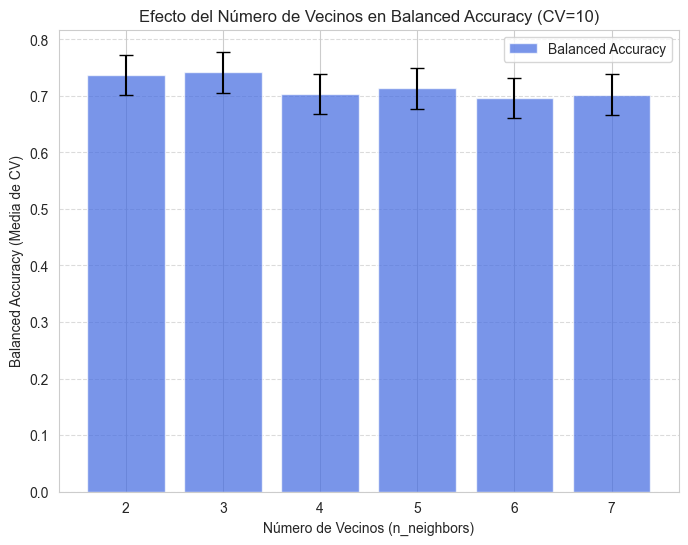

In [186]:
inner_scores_out_df = pd.concat(inner_scores_out, ignore_index=True)

grouped_scores = inner_scores_out_df.groupby('param_n_neighbors').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8,6))

plt.bar(grouped_scores['param_n_neighbors'], 
        grouped_scores['mean_balanced_accuracy'], 
        yerr=grouped_scores['std_balanced_accuracy'], 
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Número de Vecinos (n_neighbors)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto del Número de Vecinos en Balanced Accuracy (CV={inner.get_n_splits()})")
plt.xticks(grouped_scores['param_n_neighbors'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()


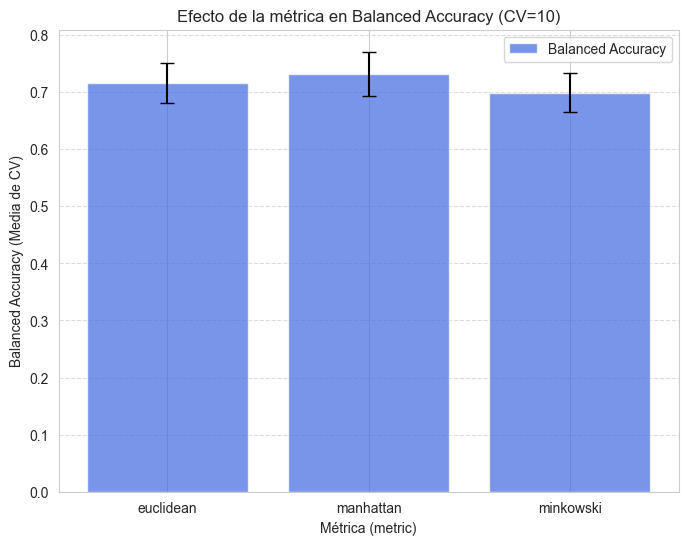

In [187]:
inner_scores_out_df = pd.concat(inner_scores_out, ignore_index=True)

grouped_scores = inner_scores_out_df.groupby('param_metric').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8,6))

plt.bar(grouped_scores['param_metric'], 
        grouped_scores['mean_balanced_accuracy'], 
        yerr=grouped_scores['std_balanced_accuracy'], 
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Métrica (metric)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto de la métrica en Balanced Accuracy (CV={inner.get_n_splits()})")
plt.xticks(grouped_scores['param_metric'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

### KNN con HPO: Mapa de calor

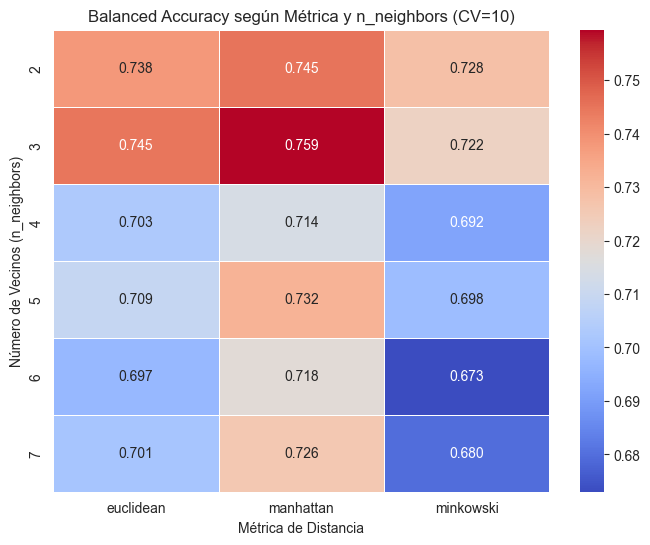

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir la lista de resultados acumulados en un DataFrame
inner_scores_out_df = pd.concat(inner_scores_out, ignore_index=True)

# Crear una tabla pivote para el heatmap (n_neighbors vs metric) mostrando mean_test_score
heatmap_data = inner_scores_out_df.pivot_table(
    index='param_n_neighbors', columns='param_metric', values='mean_test_score', aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)

plt.xlabel("Métrica de Distancia")
plt.ylabel("Número de Vecinos (n_neighbors)")
plt.title(f"Balanced Accuracy según Métrica y n_neighbors (CV={inner.get_n_splits()})")

plt.show()


# HPO con Árbol de decisión

## Tree HPO: Entrenamiento con hiperparámetros por omisión

El clasificador DecisionTreeClassifier de scikit-learn tiene los siguientes parámetros por defecto:

- criterion='gini': función usada para evaluar la calidad de cada split
- splitter='best': estrategia para elegir el split en cada nodo
- max_depth=None: por defecto el arbol se expande hasta que las hojas contengan solo instancias de una clase o min_sample_split insatancias
- min_samples_split=2: número mínimo de instancias en un nodo para continuar haciendo separaciones
- min_samples_leaf=1: número mínimo de instancias permitido en las hojas. Si un split generaría una hoja con menos instancias no se considera realizarlo
- min_weight_fraction_leaf=0.0: porcentaje de las instancias totales que tiene que contener como mínimo cada hoja. Por defecto no se establece restricción
- max_features=None: establece cuantas columnas (variables) se tienen en cuenta para buscar el mejor split. Por defecto se consideran todas las columnas del dataset
- random_state=None: semilla de aleatoriedad para elegir el split en caso de empate en el criterio de evaluación
- max_leaf_nodes=None: número máximo de hojas en el árbol final. Por defecto no se establece restricción
- min_impurity_decrease=0.0: reducción de impuridad mínima necesaria para realizar un split en un nodo. Por defecto no se establece restricción
- class_weight=None: pesos asociados a cada clase para problemas desbalanceados. Por defecto se usan pesos de 1 para todas las clases
- ccp_alpha=0.0: valor que controla la complejidad máxima en la poda del árbol de decisión mediante Minimal Cost-Complexity Pruning
- monotonic_cst=None: no se aplican restricciones de monotonicidad por defecto

In [189]:
import time

decision_tree_default = DecisionTreeClassifier(random_state=72)  # Hiperparámetros por defecto y seed 72 para romper empates de split siempre de la misma manera

start_time = time.time()
decision_tree_default.fit(X_train_transformed, y_train)
default_time_fit_tree = time.time() - start_time

start_time = time.time()
y_pred_default_tree = decision_tree_default.predict(X_test_transformed)
default_time_predict_tree = time.time() - start_time
default_score_tree = balanced_accuracy_score(y_test, y_pred_default_tree)

print("Modelo con hiperparámetros por omisión:")
print(f"Balanced Accuracy: {default_score_tree:.4f}")
print(f"Tiempo de entrenamiento default: {default_time_fit_tree:.8f} segundos")
print(f"Tiempo de predicción default: {default_time_predict_tree:.8f} segundos")

Modelo con hiperparámetros por omisión:
Balanced Accuracy: 0.8246
Tiempo de entrenamiento default: 0.03360987 segundos
Tiempo de predicción default: 0.00086617 segundos


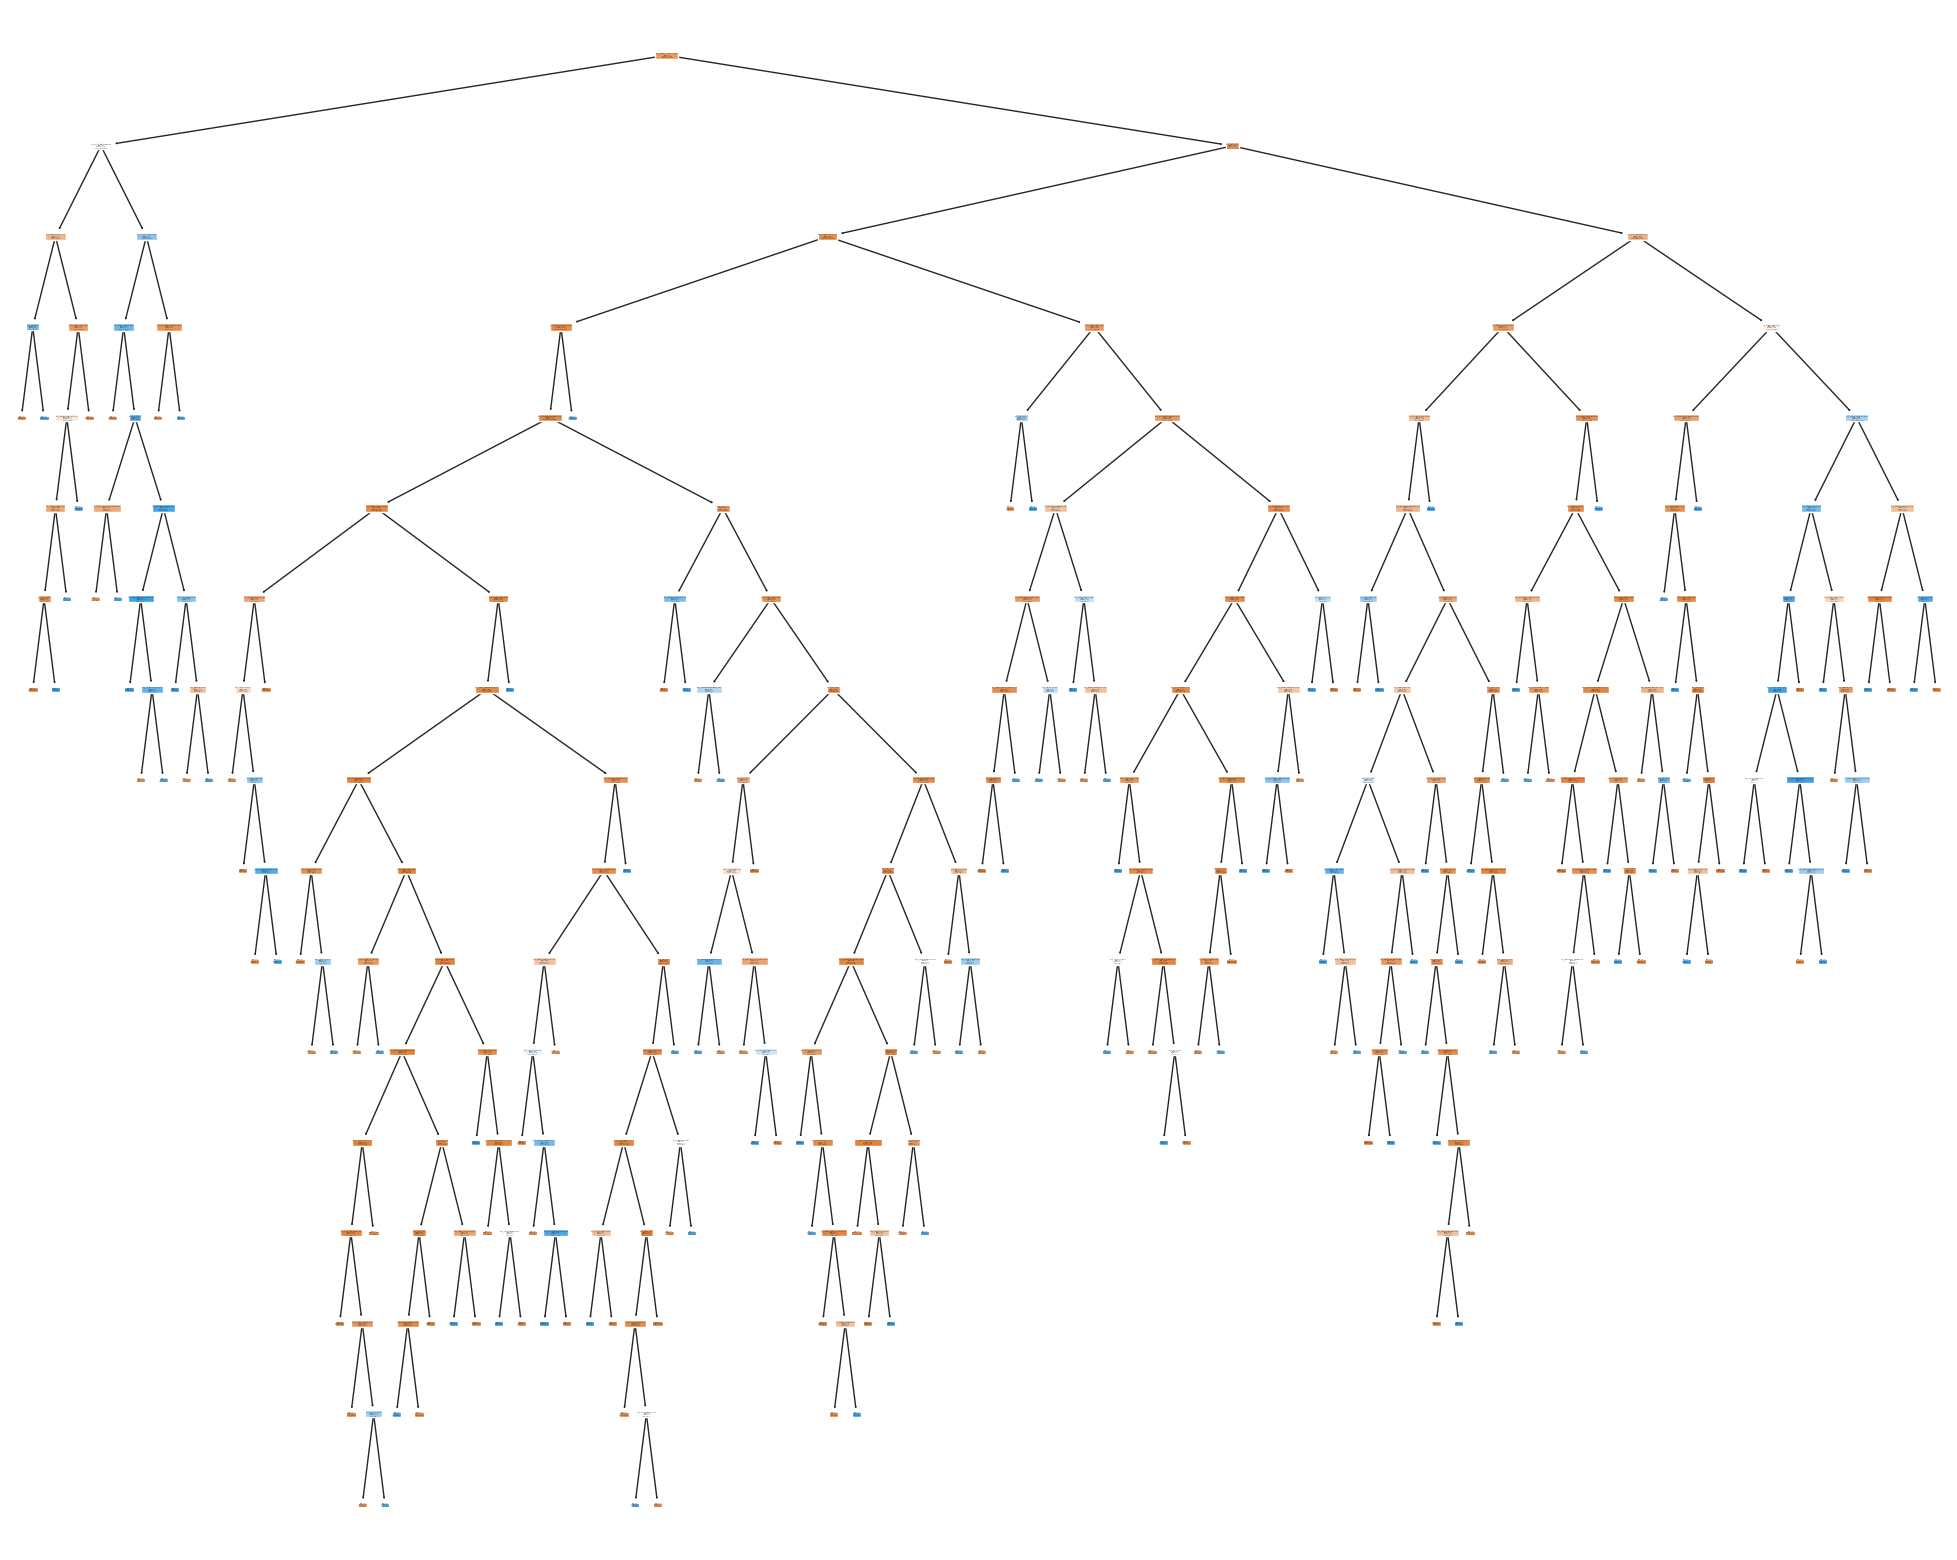

In [190]:
import matplotlib.pyplot as plt
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_default,
                   feature_names = feature_names,
                   filled=True)
# Cambiar a True para guardar la imagen en png
save_default_tree_image = False
if save_default_tree_image:
    fig.savefig("default_tree_plot.png", dpi=700, bbox_inches='tight')
    plt.close(fig)

## Evaluación de alternativas con ajustes de hiper-parámetros

In [191]:
inner_scores_out_tree = []

# Ahora entrenamos el árbol con diferentes valores para los hiperparámetros principales
params_max_depth = list(range(10,20,2))
params_max_depth.append(None)   # Añadimos None para incluir los HP del árbol default en la búsqueda en caso de que sea el mejor
# Hemos decidido parar en 18 ya que valores mayores dan resultados prácticamente iguales a max_depth=18 y max_depth=None
param_grid_decision_tree = {'max_depth': params_max_depth, # Diferentes valores de profundidad máxima
              'min_samples_split': list(range(2,12,2)), # Diferentes valores de insatncias mínimas para separar un nodo
              'min_impurity_decrease': [0.0, 0.0001, 0.001, 0.01, 0.1],
              'criterion': ['gini', 'entropy', 'log_loss'], # Criterios de evaluación de los split
              'random_state': [72], # Fijamos la misma semilla para todas las combinaciones de HP
              'class_weight': ['balanced', None] # Pesos asignados a cada clase, balance usa y para balancear los pesos
                            } 

# Hemos decidido usar 5 splits ya que nos parece suficiente para evitar bias de datos específicos y porque 10 resultaba en un tiempo de búsqueda excesivo
inner_tree = StratifiedKFold(n_splits=5, shuffle=True, random_state=72)


grid_decision_tree = GridSearchCV(
    DecisionTreeClassifier(), param_grid_decision_tree,
    cv=inner_tree, scoring='balanced_accuracy', n_jobs=-1, verbose=3
)

start_time = time.time()
grid_decision_tree.fit(X_train_transformed, y_train)
hpo_time_tree = time.time() - start_time
print(f"Hiperparámetros óptimos encontrados en {hpo_time_tree:2f}")

# Crear DataFrame con los resultados de GridSearchCV
inner_scores_df_tree = pd.DataFrame(grid_decision_tree.cv_results_)[
    ['param_max_depth', 'param_min_samples_split', 'param_criterion', 'param_class_weight', 'param_min_impurity_decrease', 
     'mean_test_score', 'std_test_score', 'rank_test_score']
]

# Añadir los resultados actuales a la lista
inner_scores_out_tree.append(inner_scores_df_tree)


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Hiperparámetros óptimos encontrados en 10.943367


In [192]:
# Obtener el mejor modelo de árbol de decisión
best_decision_tree = grid_decision_tree.best_estimator_
start_time = time.time()
best_decision_tree.fit(X_train_transformed, y_train)
best_decision_tree_time = time.time() - start_time

print("\nHPO Decision Tree:", grid_decision_tree.best_params_)
print(f"Tiempo de entrenamiento (incluyendo HPO): {hpo_time_tree+best_decision_tree_time:.2f} segundos")
print(f"Tiempo de entrenamiento del modelo decision tree default: {default_time_fit_tree:.8f} segundos")
print(f"Mejora en el tiempo de entrenamiento del modelo default con respecto al modelo que utiliza los HP optimizados = {(hpo_time_tree+best_decision_tree_time)/default_time_fit_tree}")


HPO Decision Tree: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 18, 'min_impurity_decrease': 0.001, 'min_samples_split': 2, 'random_state': 72}
Tiempo de entrenamiento (incluyendo HPO): 10.97 segundos
Tiempo de entrenamiento del modelo decision tree default: 0.03360987 segundos
Mejora en el tiempo de entrenamiento del modelo default con respecto al modelo que utiliza los HP optimizados = 326.30230545506134


Observamos que encontrar los HP óptimos y entrenar el modelo óptimo tarda alrededor de 800 veces más  que entrenar el modelo utilizando los HP por defecto.

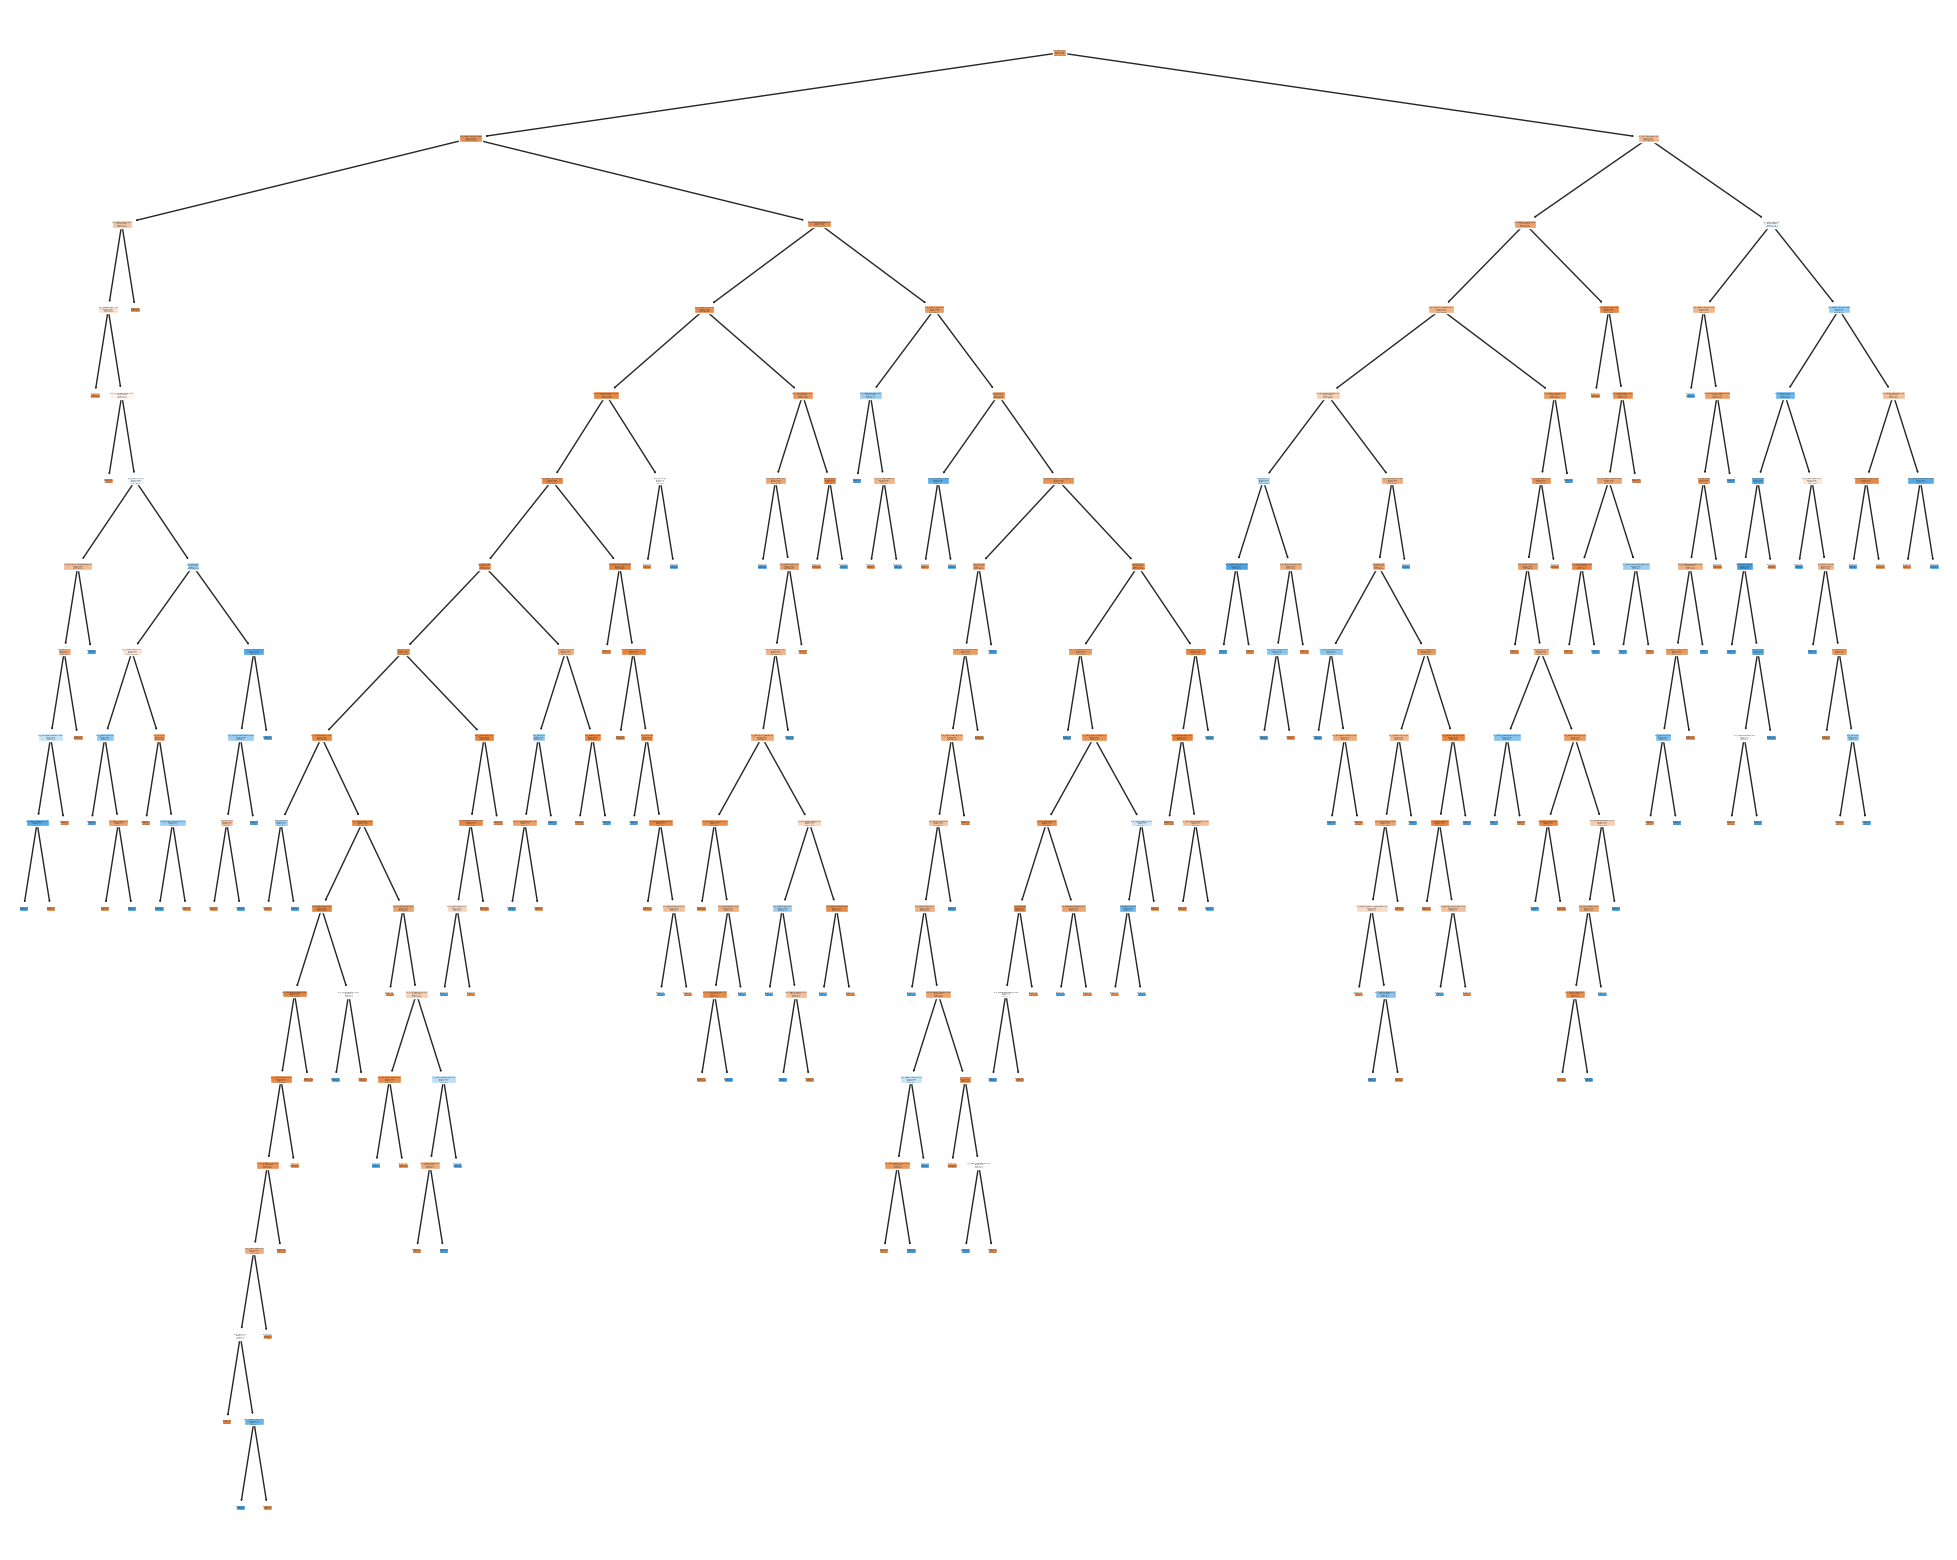

In [193]:
import matplotlib.pyplot as plt
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_decision_tree,
                   feature_names = feature_names,
                   filled=True)
# Cambiar a True para guardar la imagen en png
save_HPO_tree_image = False
if save_HPO_tree_image:
    fig.savefig("optimal_tree_plot.png", dpi=700, bbox_inches='tight')
    plt.close(fig)

## Estimación de rendimiento futuro (outer)

In [194]:
from sklearn import metrics
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score

start_time = time.time()
y_pred_tree = best_decision_tree.predict(X_test_transformed)
pred_time = time.time() - start_time

outer_score_tree = metrics.balanced_accuracy_score(y_test, y_pred_tree)
tree_cr = classification_report(y_test, y_pred_tree)

print(f"Tiempo que tarda en predecir los resultados el árbol de decisión con HP optimizados: {pred_time:.8f} segundos")

print("\n**Evaluación Final en Test (Outer Loop) del árbol de decisión**")
print(f"Balanced Accuracy en Test: {outer_score_tree:.4f}")
print(f"Accuracy en Test: {accuracy_score(y_test, y_pred_tree):.4f}")
print(f"F1-Score en Test: {f1_score(y_test, y_pred_tree):.4f}")
print(f"Classification report del árbol óptimo:\n {tree_cr}")

# Mostrar la matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_tree))

Tiempo que tarda en predecir los resultados el árbol de decisión con HP optimizados: 0.00165200 segundos

**Evaluación Final en Test (Outer Loop) del árbol de decisión**
Balanced Accuracy en Test: 0.8324
Accuracy en Test: 0.8990
F1-Score en Test: 0.7009
Classification report del árbol óptimo:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       822
           1       0.67      0.73      0.70       158

    accuracy                           0.90       980
   macro avg       0.81      0.83      0.82       980
weighted avg       0.90      0.90      0.90       980


Matriz de Confusión:
[[765  57]
 [ 42 116]]


## Matriz de confusión

Vamos a visualizar la matriz de confusion del árbol de decisión en un gráfico de calor.

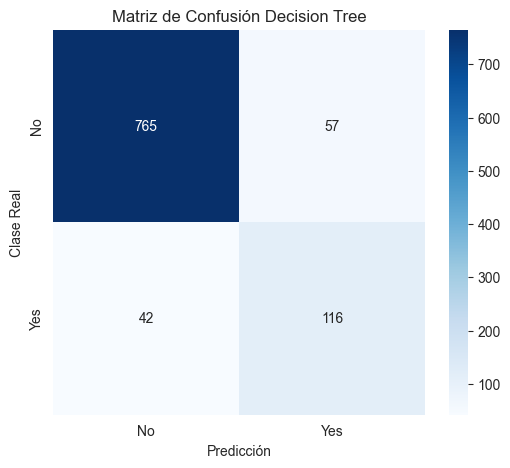

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])

plt.xlabel("Predicción")
plt.ylabel("Clase Real")
plt.title("Matriz de Confusión Decision Tree")
plt.show()

## Hiperparámetros optimizados

Representamos mediante una tabla los resultados obtenidos en el inner loop.

In [196]:
inner_scores_out_df_tree = pd.concat(inner_scores_out_tree, ignore_index=True)
inner_scores_out_df_tree = inner_scores_out_df_tree.sort_values(by='mean_test_score', ascending=False)

print("\nResultados Acumulados de Validación Cruzada")
display(inner_scores_out_df_tree)


Resultados Acumulados de Validación Cruzada


,param_max_depth,param_min_samples_split,param_criterion,param_class_weight,param_min_impurity_decrease,mean_test_score,std_test_score,rank_test_score
860,18,2,log_loss,None,0.001,0.808846,0.034487,1
885,None,2,log_loss,None,0.001,0.808846,0.034487,1
710,18,2,entropy,None,0.001,0.808846,0.034487,1
735,None,2,entropy,None,0.001,0.808846,0.034487,1
725,None,2,entropy,None,0.000,0.807934,0.034140,5
...,...,...,...,...,...,...,...,...
171,10,4,entropy,balanced,0.100,0.500000,0.000000,721
172,10,6,entropy,balanced,0.100,0.500000,0.000000,721
173,10,8,entropy,balanced,0.100,0.500000,0.000000,721
898,None,8,log_loss,None,0.100,0.500000,0.000000,721


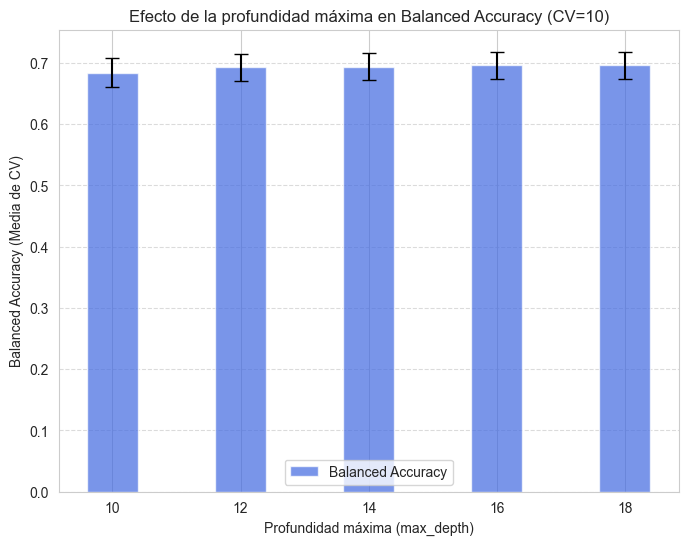

In [197]:
inner_scores_out_df_tree = pd.concat(inner_scores_out_tree, ignore_index=True)

grouped_scores_tree_max_depth = inner_scores_out_df_tree.groupby('param_max_depth').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8,6))

plt.bar(grouped_scores_tree_max_depth['param_max_depth'], 
        grouped_scores_tree_max_depth['mean_balanced_accuracy'], 
        yerr=grouped_scores_tree_max_depth['std_balanced_accuracy'], 
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Profundidad máxima (max_depth)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto de la profundidad máxima en Balanced Accuracy (CV={inner.get_n_splits()})")
plt.xticks(grouped_scores_tree_max_depth['param_max_depth'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

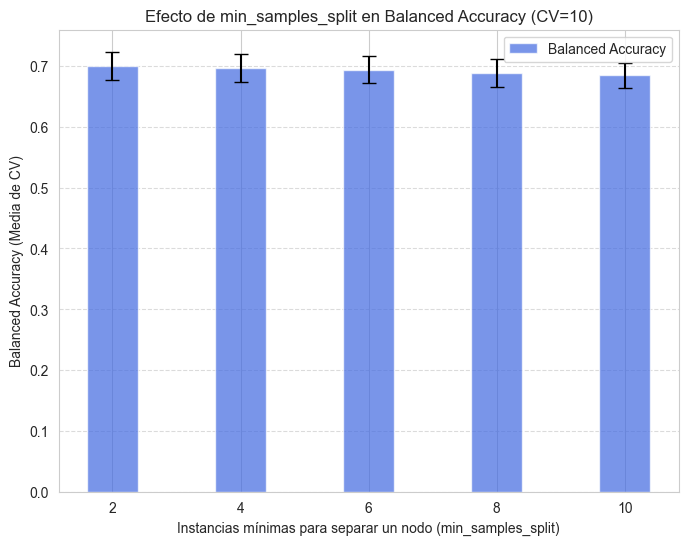

In [198]:
grouped_scores_tree_min_samples_split = inner_scores_out_df_tree.groupby('param_min_samples_split').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8,6))

plt.bar(grouped_scores_tree_min_samples_split['param_min_samples_split'], 
        grouped_scores_tree_min_samples_split['mean_balanced_accuracy'], 
        yerr=grouped_scores_tree_min_samples_split['std_balanced_accuracy'], 
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Instancias mínimas para separar un nodo (min_samples_split)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto de min_samples_split en Balanced Accuracy (CV={inner.get_n_splits()})")
plt.xticks(grouped_scores_tree_min_samples_split['param_min_samples_split'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

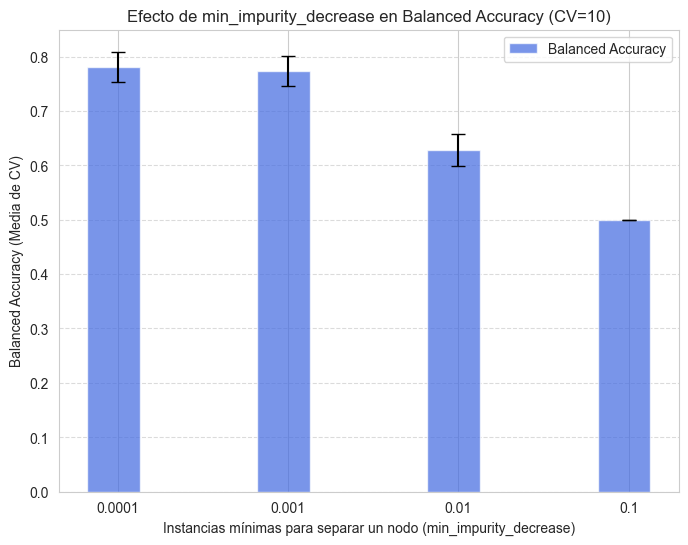

In [199]:
grouped_scores_tree_min_impurity_decrease = inner_scores_out_df_tree.groupby('param_min_impurity_decrease').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

import numpy as np

x_values = grouped_scores_tree_min_impurity_decrease['param_min_impurity_decrease']
y_values = grouped_scores_tree_min_impurity_decrease['mean_balanced_accuracy']
y_errors = grouped_scores_tree_min_impurity_decrease['std_balanced_accuracy']

# Quitamos el valor de x 0.0 para poder convertir a escala logarítmica y evitar divide by 0 error
valid_mask = x_values > 0
x_values = x_values[valid_mask]
y_values = y_values[valid_mask]
y_errors = y_errors[valid_mask]

plt.figure(figsize=(8,6))

# Calculamos el espaciado entre barras en escala log10
x_sorted = np.sort(x_values)
bar_widths = np.diff(np.log10(x_sorted)) # Diferencias entre valores de x en escala log10
bar_widths = np.append(bar_widths, bar_widths[-1])  # Hay que extender bar_widths con un valor más ya que np.diff() da |x_values|-1 valores

# Escalamos el resultado anterior para que las barras no intersecten
bar_widths = 10**(np.log10(x_sorted) - bar_widths * 0.5) - x_sorted

plt.bar(x_sorted, y_values, 
        yerr=y_errors, 
        capsize=5, 
        color='royalblue', 
        alpha=0.7, 
        label='Balanced Accuracy', 
        width=bar_widths)

plt.xscale('log')  # Eje x en escala log10
plt.xlabel("Instancias mínimas para separar un nodo (min_impurity_decrease)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto de min_impurity_decrease en Balanced Accuracy (CV={inner.get_n_splits()})")

plt.xticks(x_sorted, labels=[str(x) for x in x_sorted])  

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()


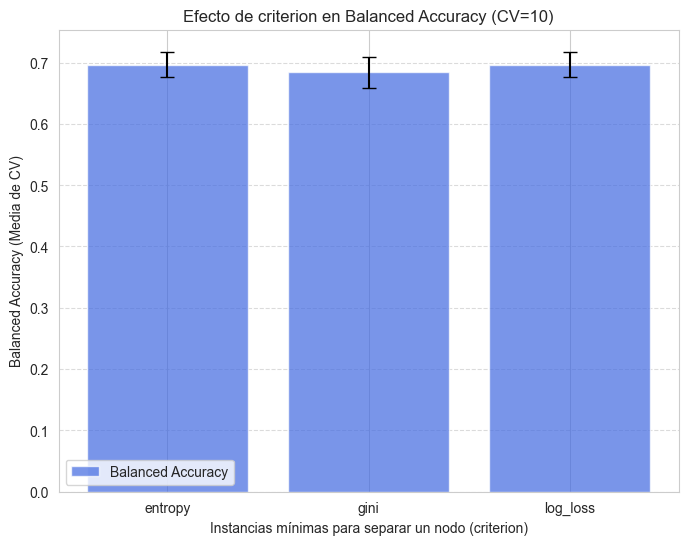

In [200]:
grouped_scores_tree_criterion = inner_scores_out_df_tree.groupby('param_criterion').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8, 6))

plt.bar(grouped_scores_tree_criterion['param_criterion'],
        grouped_scores_tree_criterion['mean_balanced_accuracy'],
        yerr=grouped_scores_tree_criterion['std_balanced_accuracy'],
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Instancias mínimas para separar un nodo (criterion)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto de criterion en Balanced Accuracy (CV={inner.get_n_splits()})")
plt.xticks(grouped_scores_tree_criterion['param_criterion'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

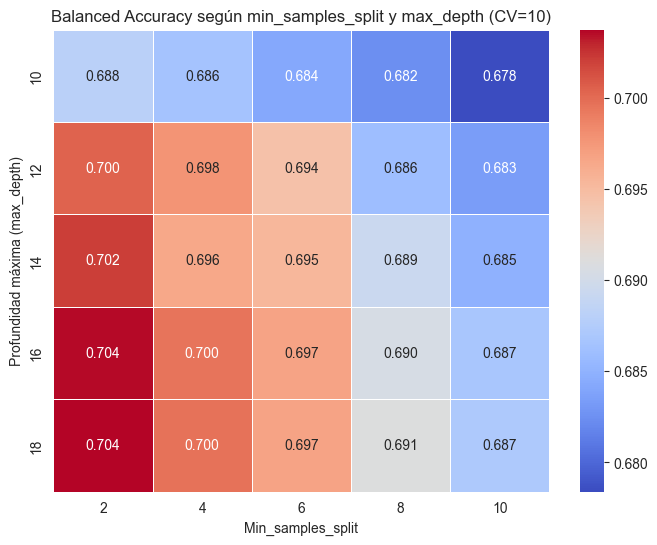

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir la lista de resultados acumulados en un DataFrame
inner_scores_out_df_tree = pd.concat(inner_scores_out_tree, ignore_index=True)

# Crear una tabla pivote para el heatmap (max_depth vs metric) mostrando mean_test_score
heatmap_data_tree = inner_scores_out_df_tree.pivot_table(
    index='param_max_depth', columns='param_min_samples_split', values='mean_test_score', aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data_tree, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)

plt.xlabel("Min_samples_split")
plt.ylabel("Profundidad máxima (max_depth)")
plt.title(f"Balanced Accuracy según min_samples_split y max_depth (CV={inner.get_n_splits()})")

plt.show()

# Modelos Lineales: Regresión Logística

## Regresión logística SIN regularización (default)
### Entrenamiento

In [202]:
from sklearn.linear_model import LogisticRegression

logreg_default = LogisticRegression(penalty=None, random_state=72)

start = time.time()
logreg_default.fit(X_train_transformed, y_train)
default_time = time.time() - start

print("Tiempo de entrenamiento de regresión logística SIN regularización (default): {:.4f} segundos".format(default_time))

Tiempo de entrenamiento de regresión logística SIN regularización (default): 0.0257 segundos


### Métricas: balanced accuracy, TPR, TNR, accuracy y confusion matrix

Evaluación Inner para Logistic Regression SIN regularización (default):
Balanced Accuracy: 0.6279
Accuracy: 0.8561
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1644
           1       0.61      0.29      0.39       316

    accuracy                           0.86      1960
   macro avg       0.74      0.63      0.66      1960
weighted avg       0.83      0.86      0.83      1960

Matriz de Confusión:
[[1586   58]
 [ 224   92]]
TPR: 0.2911
TNR: 0.9647


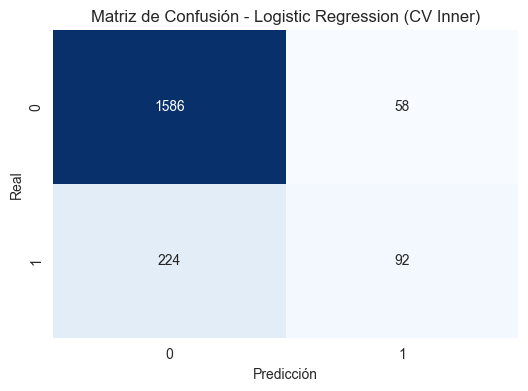

In [203]:
# Evaluación Inner: predicciones mediante validación cruzada sobre el conjunto de entrenamiento.
y_pred_cv_logreg = cross_val_predict(logreg_default, X_train_transformed, y_train, cv=5)

# Calcular métricas usando los datos de entrenamiento
inner_bal_acc_logreg = balanced_accuracy_score(y_train, y_pred_cv_logreg)
inner_acc_logreg = accuracy_score(y_train, y_pred_cv_logreg)
inner_conf_matrix_logreg = confusion_matrix(y_train, y_pred_cv_logreg)
inner_class_report_logreg = classification_report(y_train, y_pred_cv_logreg)

print("Evaluación Inner para Logistic Regression SIN regularización (default):")
print("Balanced Accuracy: {:.4f}".format(inner_bal_acc_logreg))
print("Accuracy: {:.4f}".format(inner_acc_logreg))
print("Classification Report:")
print(inner_class_report_logreg)
print("Matriz de Confusión:")
print(inner_conf_matrix_logreg)

# Calcular TPR y TNR
tn, fp, fn, tp = inner_conf_matrix_logreg.ravel()
TPR_logreg = tp / (tp + fn)
TNR_logreg = tn / (tn + fp)
print("TPR: {:.4f}".format(TPR_logreg))
print("TNR: {:.4f}".format(TNR_logreg))

# Visualizar la matriz de confusión como un heatmap.
plt.figure(figsize=(6, 4))
sns.heatmap(inner_conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Logistic Regression (CV Inner)")
plt.show()


## Regresión logística con regularización l1 default

### Entrenamiento

In [204]:
logreg_l1_default = LogisticRegression(penalty='l1', solver='liblinear', random_state=72)

start_default = time.time()
logreg_l1_default.fit(X_train_transformed, y_train)
default_time_fit = time.time() - start_default
print("Tiempo de entrenamiento Logistic Regression L1 default: {:.4f} segundos".format(default_time_fit))


Tiempo de entrenamiento Logistic Regression L1 default: 0.0385 segundos


### Resultados de Log Reg L1 default: balanced accuracy, TPR / TNR, accuracy y confusion matrix (inner)

Evaluación Inner para Logistic Regression L1 default:
Balanced Accuracy: 0.6072
Accuracy: 0.8556
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1644
           1       0.64      0.24      0.35       316

    accuracy                           0.86      1960
   macro avg       0.75      0.61      0.63      1960
weighted avg       0.83      0.86      0.83      1960

Matriz de Confusión:
[[1601   43]
 [ 240   76]]
TPR: 0.2405
TNR: 0.9738


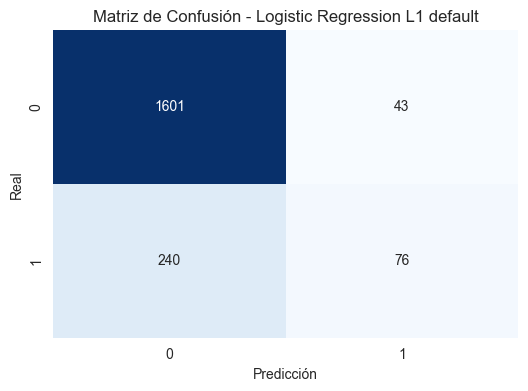

In [205]:
# Evaluación Inner: predicciones mediante validación cruzada
y_pred_cv_logreg_l1 = cross_val_predict(logreg_l1_default, X_train_transformed, y_train, cv=5)

# Calcular métricas en el conjunto de entrenamiento (evaluación inner)
inner_bal_acc_logreg_l1 = balanced_accuracy_score(y_train, y_pred_cv_logreg_l1)
inner_acc_logreg_l1 = accuracy_score(y_train, y_pred_cv_logreg_l1)
inner_conf_matrix_logreg_l1 = confusion_matrix(y_train, y_pred_cv_logreg_l1)
inner_class_report_logreg_l1 = classification_report(y_train, y_pred_cv_logreg_l1)

print("Evaluación Inner para Logistic Regression L1 default:")
print("Balanced Accuracy: {:.4f}".format(inner_bal_acc_logreg_l1))
print("Accuracy: {:.4f}".format(inner_acc_logreg_l1))
print("Classification Report:")
print(inner_class_report_logreg_l1)
print("Matriz de Confusión:")
print(inner_conf_matrix_logreg_l1)

# Calcular TPR (sensibilidad) y TNR (especificidad) a partir de la matriz de confusión
tn, fp, fn, tp = inner_conf_matrix_logreg_l1.ravel()
TPR_logreg_l1 = tp / (tp + fn)
TNR_logreg_l1 = tn / (tn + fp)
print("TPR: {:.4f}".format(TPR_logreg_l1))
print("TNR: {:.4f}".format(TNR_logreg_l1))

# Visualizar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(inner_conf_matrix_logreg_l1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Logistic Regression L1 default")
plt.show()


## Regresión logística con regularización L1 optimizada (HPO)
### INNER LOOP de Regresión logística L1 HPO 

In [206]:
logreg_l1_hpo = LogisticRegression(penalty='l1', max_iter=1000, random_state=72)

# Definimos el grid de hiperparámetros a optimizar
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],                # Fuerza de regularización (inverso), es el HP más importante
    'solver': ['liblinear', 'saga'],             # Algoritmo de optimización compatible con L1
    'class_weight': [None, 'balanced'],          # Ajustar pesos para contrarrestar el desbalanceo
    'tol': [1e-4, 1e-3, 1e-2]                     # Tolerancia para la convergencia
}

# validación cruzada interna con KFold
inner_cv = KFold(n_splits=10, shuffle=True, random_state=72)

# GridSearchCV para la HPO
grid_search_l1 = GridSearchCV(
    logreg_l1_hpo,
    param_grid,
    cv=inner_cv,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

# Medimos el tiempo de entrenamiento con HPO
start_hpo = time.time()
grid_search_l1.fit(X_train_transformed, y_train)
hpo_time = time.time() - start_hpo

# Extraer los resultados en un dataframe
results_df = pd.DataFrame(grid_search_l1.cv_results_)

# Seleccionar columnas 
results_df = results_df[
    ['param_C', 'param_solver', 'param_class_weight', 'param_tol', 
     'mean_test_score', 'std_test_score', 'rank_test_score']
]

# Ordenar por el mejor Balanced Accuracy
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Mostrar el DataFrame ordenado
display(results_df)

print("Mejor hiperparámetros encontrados para modelo de regresión logística con regularización L1:")
print(grid_search_l1.best_params_)
print("Mejor Balanced Accuracy (CV):", grid_search_l1.best_score_)
print(f"\nTiempo de entrenamiento (HPO) en el conjunto de entrenamiento: {hpo_time:.4f} segundos")



Fitting 10 folds for each of 60 candidates, totalling 600 fits


,param_C,param_solver,param_class_weight,param_tol,mean_test_score,std_test_score,rank_test_score
20,0.10,liblinear,balanced,0.0100,0.728438,0.050238,1
18,0.10,liblinear,balanced,0.0001,0.727826,0.049856,2
19,0.10,liblinear,balanced,0.0010,0.727826,0.049856,2
23,0.10,saga,balanced,0.0100,0.722944,0.050899,4
21,0.10,saga,balanced,0.0001,0.721718,0.053741,5
22,0.10,saga,balanced,0.0010,0.721718,0.053741,5
56,100.00,liblinear,balanced,0.0100,0.717920,0.057120,7
57,100.00,saga,balanced,0.0001,0.717637,0.057418,8
55,100.00,liblinear,balanced,0.0010,0.717637,0.057418,8
54,100.00,liblinear,balanced,0.0001,0.717637,0.057418,8


Mejor hiperparámetros encontrados para modelo de regresión logística con regularización L1:
{'C': 0.1, 'class_weight': 'balanced', 'solver': 'liblinear', 'tol': 0.01}
Mejor Balanced Accuracy (CV): 0.728437993919339

Tiempo de entrenamiento (HPO) en el conjunto de entrenamiento: 4.6950 segundos


In [207]:
# Obtener el mejor modelo obtenido en HPO
best_logreg_l1 = grid_search_l1.best_estimator_

# Medir el tiempo de entrenamiento del mejor modelo sobre todo el conjunto de entrenamiento
start_best = time.time()
best_logreg_l1.fit(X_train_transformed, y_train)
best_logreg_l1_time = time.time() - start_best

# Tiempo total del proceso optimizado (HPO + entrenamiento del mejor modelo)
total_hpo_time = hpo_time + best_logreg_l1_time

print("Tiempo de entrenamiento del modelo default: {:.8f} segundos".format(default_time_fit))
print("Tiempo de entrenamiento del proceso HPO (grid search): {:.4f} segundos".format(hpo_time))
print("Tiempo de entrenamiento del best_logreg_l1: {:.4f} segundos".format(best_logreg_l1_time))
print("Tiempo total (HPO + entrenamiento del best modelo): {:.4f} segundos".format(total_hpo_time))

# Calcular la mejora en el tiempo de entrenamiento comparando el total optimizado con el default
mejora_tiempo = total_hpo_time / default_time_fit
print("Mejora en el tiempo de entrenamiento (modelo HPO / modelo default) = {:.4f}".format(mejora_tiempo))


Tiempo de entrenamiento del modelo default: 0.03851700 segundos
Tiempo de entrenamiento del proceso HPO (grid search): 4.6950 segundos
Tiempo de entrenamiento del best_logreg_l1: 0.0094 segundos
Tiempo total (HPO + entrenamiento del best modelo): 4.7044 segundos
Mejora en el tiempo de entrenamiento (modelo HPO / modelo default) = 122.1381


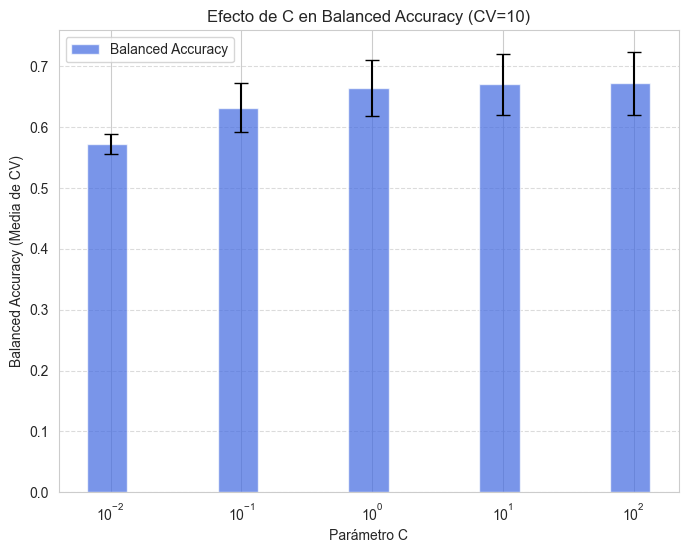

In [208]:
results_df_param_C = results_df.groupby('param_C').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

x_values = results_df_param_C['param_C']
y_values = results_df_param_C['mean_balanced_accuracy']
y_errors = results_df_param_C['std_balanced_accuracy']

plt.figure(figsize=(8,6))

# Calculamos el espaciado entre barras en escala log10
x_sorted = np.sort(x_values)
bar_widths = np.diff(np.log10(x_sorted)) # Diferencias entre valores de x en escala log10
bar_widths = np.append(bar_widths, bar_widths[-1])  # Hay que extender bar_widths con un valor más ya que np.diff() da |x_values|-1 valores

# Escalamos el resultado anterior para que las barras no intersecten
bar_widths = 10**(np.log10(x_sorted) - bar_widths * 0.5) - x_sorted

plt.bar(x_sorted, y_values, 
        yerr=y_errors, 
        capsize=5, 
        color='royalblue', 
        alpha=0.7, 
        label='Balanced Accuracy', 
        width=bar_widths)

plt.xscale('log')
plt.xlabel("Parámetro C")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto de C en Balanced Accuracy (CV={inner.get_n_splits()})")
plt.xticks(results_df_param_C['param_C'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

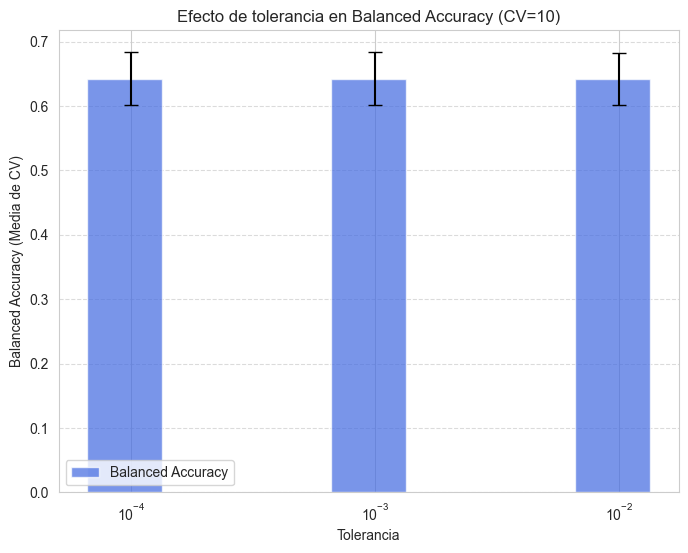

In [209]:
results_df_param_tol = results_df.groupby('param_tol').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

x_values = results_df_param_tol['param_tol']
y_values = results_df_param_tol['mean_balanced_accuracy']
y_errors = results_df_param_tol['std_balanced_accuracy']

plt.figure(figsize=(8,6))

# Calculamos el espaciado entre barras en escala log10
x_sorted = np.sort(x_values)
bar_widths = np.diff(np.log10(x_sorted)) # Diferencias entre valores de x en escala log10
bar_widths = np.append(bar_widths, bar_widths[-1])  # Hay que extender bar_widths con un valor más ya que np.diff() da |x_values|-1 valores

# Escalamos el resultado anterior para que las barras no intersecten
bar_widths = 10**(np.log10(x_sorted) - bar_widths * 0.5) - x_sorted

plt.bar(x_sorted, y_values, 
        yerr=y_errors, 
        capsize=5, 
        color='royalblue', 
        alpha=0.7, 
        label='Balanced Accuracy', 
        width=bar_widths)

plt.xscale('log')
plt.xlabel("Tolerancia")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto de tolerancia en Balanced Accuracy (CV={inner.get_n_splits()})")
plt.xticks(results_df_param_tol['param_tol'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()
# TODO: no muestra mucha información, podemos considerar quitarlo

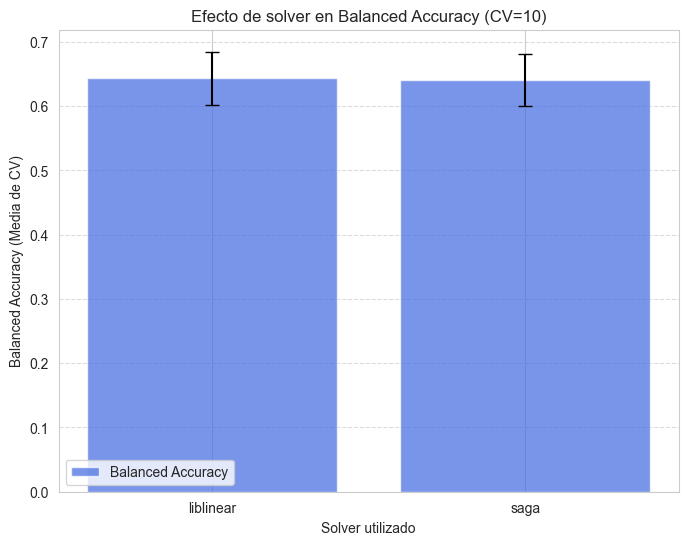

In [210]:
results_df_param_solver = results_df.groupby('param_solver').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8, 6))

plt.bar(results_df_param_solver['param_solver'],
        results_df_param_solver['mean_balanced_accuracy'],
        yerr=results_df_param_solver['std_balanced_accuracy'],
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Solver utilizado")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto de solver en Balanced Accuracy (CV={inner.get_n_splits()})")
plt.xticks(results_df_param_solver['param_solver'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()
# TODO: no muestra mucha información, podemos considerar quitarlo

### Resultados de Log Reg L1 con HPO: balanced accuracy, TPR / TNR, accuracy y confusion matrix (inner)


Evaluación Inner para Logistic Regression L1 optimizada (HPO):
Balanced Accuracy (CV): 0.7244

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.73      0.82      1644
           1       0.34      0.72      0.46       316

    accuracy                           0.73      1960
   macro avg       0.63      0.72      0.64      1960
weighted avg       0.84      0.73      0.76      1960

Matriz de Confusión (Inner):
[[1201  443]
 [  89  227]]
TPR: 0.7184
TNR: 0.7305


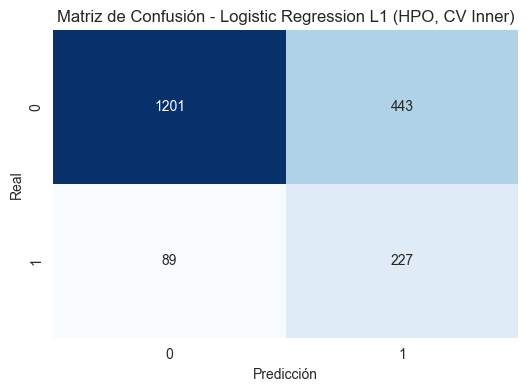

In [211]:
# Extraemos el modelo optimizado
best_logreg_l1 = grid_search_l1.best_estimator_

# Usamos cross_val_predict para obtener las predicciones en validación cruzada
y_pred_cv_hpo = cross_val_predict(best_logreg_l1, X_train_transformed, y_train, cv=5)

# Calcular las métricas en el conjunto de entrenamiento
inner_bal_acc_hpo = balanced_accuracy_score(y_train, y_pred_cv_hpo)
inner_class_report_hpo = classification_report(y_train, y_pred_cv_hpo, zero_division=0)

print("Evaluación Inner para Logistic Regression L1 optimizada (HPO):")
print(f"Balanced Accuracy (CV): {inner_bal_acc_hpo:.4f}")
print("\nClassification Report:\n", inner_class_report_hpo)

# Calcular la matriz de confusión
conf_matrix_hpo = confusion_matrix(y_train, y_pred_cv_hpo)
print("Matriz de Confusión (Inner):")
print(conf_matrix_hpo)

# Calcular TPR y TNR
tn, fp, fn, tp = conf_matrix_hpo.ravel()
TPR_hpo = tp / (tp + fn)
TNR_hpo = tn / (tn + fp)
print(f"TPR: {TPR_hpo:.4f}")
print(f"TNR: {TNR_hpo:.4f}")

# Visualizar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_hpo, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Logistic Regression L1 (HPO, CV Inner)")
plt.show()

### Extracción de atributos más relevantes

In [212]:
import numpy as np

# Extraer la importancia de las características (coeficientes) del modelo L1 optimizado
# La regularización L1 tiende a poner a cero coeficientes de variables menos importantes.
coefficients = best_logreg_l1.coef_.flatten()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
}).sort_values(by='Absolute Coefficient', ascending=False)

print("\nImportancia de las características (coeficientes) del modelo L1 optimizado:")
display(importance_df)


Importancia de las características (coeficientes) del modelo L1 optimizado:


,Feature,Coefficient,Absolute Coefficient
0,num__hrs,1.786595,1.786595
19,num__YearsWithCurrManager,-1.461073,1.461073
15,num__TotalWorkingYears,-1.334586,1.334586
37,cat__MaritalStatus_Single,1.147098,1.147098
18,num__YearsSinceLastPromotion,0.774177,0.774177
5,num__JobSatisfaction,-0.575978,0.575978
12,num__NumCompaniesWorked,0.499490,0.499490
6,num__WorkLifeBalance,-0.469982,0.469982
31,cat__JobRole_Manufacturing Director,-0.454776,0.454776
4,num__EnvironmentSatisfaction,-0.434615,0.434615


Podemos visualizar estos coeficientes usando seaborn y matplotlib

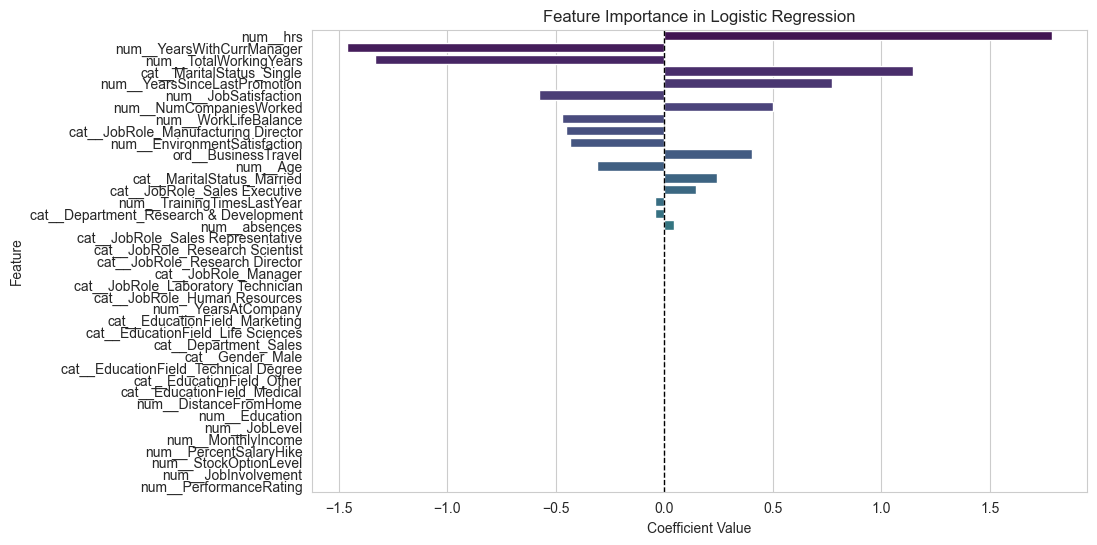

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordenamos los coeficientes por valor absoluto para una mejor visualización
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_features = np.array(feature_names)[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_coefficients, y=sorted_features, hue=sorted_features, palette="viridis", legend=False)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance in Logistic Regression")
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)  # Vertical en 0
plt.show()

Las curvas ROC son una manera de visualizar la capacidad de predicción de una regresión logística, queda bastante bien explicado aquí https://www.graphpad.com/guides/prism/latest/curve-fitting/reg_logistic_roc_curves.htm
No lo piden específicamente pero es una buena forma de visualizar el modelo

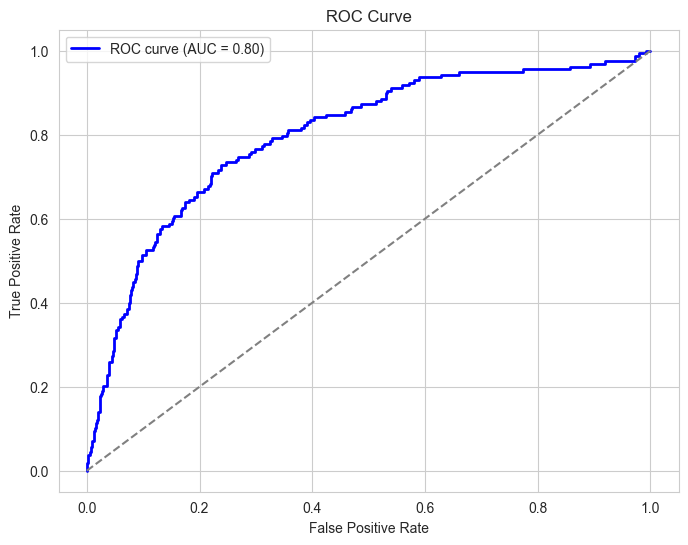

In [214]:
from sklearn.metrics import roc_curve, auc

# Predicción de las probabilidades
y_scores = best_logreg_l1.predict_proba(X_test_transformed)[:, 1]  # Probabilidad de la clase 1

# Calculamos la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot de la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Recta del modelo aleatorio
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Esto es otra forma de visualizar las probabilidades calculadas del modelo, viene explicado aquí: https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html

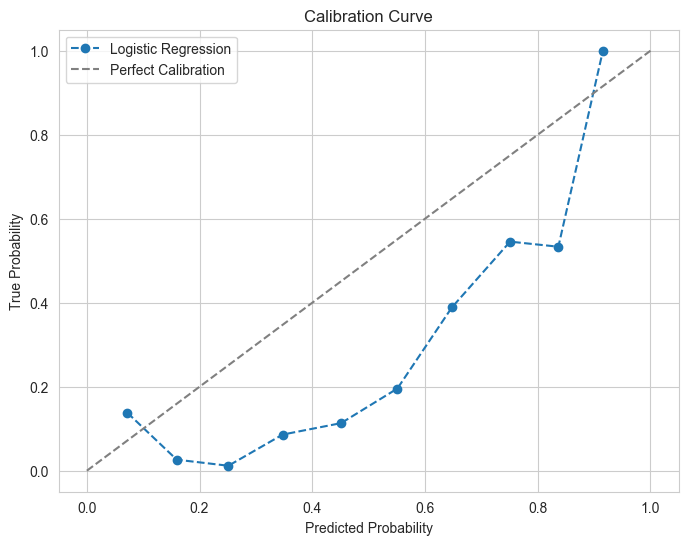

In [215]:
from sklearn.calibration import calibration_curve

# Obtener las probabilidades de la predicción
y_probs = best_logreg_l1.predict_proba(X_test_transformed)[:, 1]

# Curva de calibración
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle="--", label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()